<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 

  
    
Ссылка на презентацию : 
https://disk.yandex.ru/i/CB4hdiAYFteTEg
    
Дашборд:
https://public.tableau.com/app/profile/sergei.loginov/viz/Amountofgoodsdashboard/Dashboard1
    
</div>

## Шаг 1. Первичное изучение данных и импорт библиотек

- Импортировать необходимые библиотеки для работы с данными;
- Получить данные о клиентах банка;
- Проверить данные на явные дубликаты, пропуски в данных, информации о датасете, типах данных, подсчитать количество уникальных значений в столбцах;
- Выполнить первичный подсчет аномальных выбросов в данных;
- Проверить наличие дубликатов в категориальных признаках.

In [1]:
#импортируем основные библиотеки
import pandas as pd
import random
import seaborn as sns 
from itertools import combinations
import scipy.stats as st
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
import math as mth
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from plotly import graph_objects as go

In [2]:
#откроем файл
data = pd.read_csv('~/work/bank_scrooge.csv', sep='\,')
display(data.sample(5))

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
1757,146050,799.0,Рыбинск,Ж,34.0,5,502437.07,2,0,1,110588.32,0
5476,192399,757.0,Ростов,М,42.0,2,263384.84,2,1,1,183836.66,0
2202,162844,726.0,Ярославль,М,46.0,0,NaN,1,1,1,188240.50,0
4342,120125,835.0,Рыбинск,Ж,52.0,2,255847.61,2,1,1,61505.81,0
9477,98741,919.0,Ярославль,М,29.0,5,383644.93,2,1,1,270127.98,1


In [3]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data, *cols):
    display(data.sample(5))
    print('______')
    data_duplicated = pd.DataFrame({'Число дубликатов': [data.duplicated().sum()], 'Процент дубликатов ': [(data.duplicated().mean() *100).round(2)]})
    display(data_duplicated)
    print('______')
    print('Число пропусков:')
    missing_values_count = data.isna().sum()
    missing_values_data = pd.DataFrame(missing_values_count[missing_values_count > 0], columns=['Количество пропусков'])
    missing_values_data['Процент пропусков от общего количества данных'] = (missing_values_count / len(data) * 100).round(2)
    display(missing_values_data)
    print('______')
    print('Информация о датасете')
    data.info(null_counts = False)
    print('______')
    print('Типы данных')
    data_type = data.dtypes.reset_index()
    data_type.columns = ['Count', 'Column type']
    data_type = data_type.groupby('Column type').agg('count').reset_index()
    display(data_type)
    print('______')
    print('Подсчет количества данных')
    len_data = pd.DataFrame({'Число строк данных': [len(data)]})
    for col in cols:
        len_data.loc[0, f'Число уникальных {col}':] = data[col].nunique()
    display(len_data)
    print('______')
    for col in cols:
        print(f'Количество уникальных называний в столбце "{col}"')
        name_values_count = data[col].value_counts().reset_index()
        name_values_count.columns = ['value', 'count']
        display(name_values_count)
        print('______')  

In [4]:
get_info(data, *data.columns)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
3870,117555,903.0,Рыбинск,М,56.0,0,NaN,1,1,0,110065.52,0
2664,174748,815.0,Ростов,Ж,68.0,1,203697.17,2,1,1,92809.29,0
518,221751,824.0,Рыбинск,М,30.0,3,146960.97,2,0,1,37882.88,1
5825,173450,796.0,Ярославль,М,41.0,5,1310180.51,4,1,1,230116.85,1
8809,117208,905.0,Ярославль,Ж,36.0,0,NaN,1,1,1,216221.05,0


______


,Число дубликатов,Процент дубликатов
0,0,0.0


______
Число пропусков:


,Количество пропусков,Процент пропусков от общего количества данных
age,26,0.26
balance,2295,22.95


______
Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   USERID         int64  
 1   score          float64
 2   city           object 
 3   gender         object 
 4   age            float64
 5   equity         int64  
 6   balance        float64
 7   products       int64  
 8   credit_card    int64  
 9   last_activity  int64  
 10  EST_SALARY     float64
 11  churn          int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
______
Типы данных


,Column type,Count
0,int64,6
1,float64,4
2,object,2


______
Подсчет количества данных


,Число строк данных
0,10000


______
Количество уникальных называний в столбце "USERID"


,value,count
0,227795,2
1,198635,2
2,210898,2
3,210627,2
4,202983,2
...,...,...
9922,146877,1
9923,214466,1
9924,226756,1
9925,173510,1


______
Количество уникальных называний в столбце "score"


,value,count
0,900.0,80
1,889.0,75
2,899.0,70
3,894.0,70
4,908.0,68
...,...,...
343,673.0,1
344,998.0,1
345,666.0,1
346,654.0,1


______
Количество уникальных называний в столбце "city"


,value,count
0,Ярославль,5888
1,Рыбинск,2695
2,Ростов,1417


______
Количество уникальных называний в столбце "gender"


,value,count
0,М,5005
1,Ж,4995


______
Количество уникальных называний в столбце "age"


,value,count
0,36.0,414
1,37.0,402
2,33.0,392
3,35.0,388
4,34.0,384
...,...,...
63,83.0,3
64,82.0,2
65,84.0,2
66,86.0,2


______
Количество уникальных называний в столбце "equity"


,value,count
0,0,2592
1,5,1918
2,4,1850
3,3,1543
4,2,1052
5,1,774
6,6,161
7,7,80
8,8,17
9,9,13


______
Количество уникальных называний в столбце "balance"


,value,count
0,0.00,2
1,26.00,2
2,39.00,2
3,38.00,2
4,1500606.59,1
...,...,...
7696,276.00,1
7697,318509.47,1
7698,644931.28,1
7699,302662.71,1


______
Количество уникальных называний в столбце "products"


,value,count
0,2,5126
1,1,3341
2,3,1039
3,4,474
4,5,19
5,0,1


______
Количество уникальных называний в столбце "credit_card"


,value,count
0,1,6804
1,0,3196


______
Количество уникальных называний в столбце "last_activity"


,value,count
0,1,5235
1,0,4765


______
Количество уникальных называний в столбце "EST_SALARY"


,value,count
0,381868.89,2
1,49742.87,2
2,108250.17,2
3,176348.18,2
4,433829.32,1
...,...,...
9991,165970.28,1
9992,220657.46,1
9993,74324.89,1
9994,97081.83,1


______
Количество уникальных называний в столбце "churn"


,value,count
0,0,8180
1,1,1820


______


### Вывод Шаг 1. 

- В результате первичного исследования датафрейма были зафиксированы следующие наблюдения:
    1. Явные дубликаты не обнаружены 
    2. В столбце age выявлено 26 пропусков, что составляет 0.26% от общего числа строк   
       В столбце balance выявлено 2295 пропусков, что составляет 22.95% от общего числа строк
    3. Каждый столбец датафрейма имеет корректный тип данных, 
    4. Типы данных: 
                   int64	6  
                   float64	4  
                   object	2  
    5. Общее количество строк в датафрейме - 10.000 
    6. Несмотря на отсутсвие явных дубликатов, в столбце 'USERID' обнаружены повторяющиеся значения
    7. Дубликатов в категориальных признаках не обнаружено
    
##### Изменения:
1. В столбце 'age' пропуски не имеют аномальной природы и т.к. их количество небольшое, мы заполним их медианой - это не повлияет на результаты анализа, а также приведем столбец к корректному типу данных
2. В столбце 'balance' большое количество пропусков, но их изменение может повлиять на результаты исследования, поэтому рекомендуется оставить их без изменения
3. Было обнаружено наличие повторяющихся значений в столбце 'USERID', что требует дополнительного исследования дубликатов в данном столбце
4. Привести названия колонок к нижнему регистру и поправить названия для удобной работы с данными
____
____

## Шаг 2. Предобработка данных 

- Преобразовать данные в удобный для анализа формат;
- Обработать пропуски;
- Обработать дубликаты;
- Выполнить поиск дубликатов в данных по сегментам (например количество пропусков по городам, полу) и определить в каких сегментах больше пропусков в данных;
- Построить boxplot по числовым данным для определения аномалий и выбросов.


### Преобразование данных в удобный для анализа формат

In [5]:
#приводим названия столбцов к нижнему регистру и удобному формату 
data.columns = [x.lower() for x in data.columns]

In [6]:
#изменим название столбца userid
data = data.rename(columns = {'userid': 'user_id'})

In [7]:
data.head(0)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


#### Промежуточный вывод

- Данные были приведены к удобному для исследования формату
___

### Обработка пропусков 

In [8]:
#в столбце age обработаем пропуски 
data_age_median = data['age'].median()
data['age'] = data['age'].fillna(data_age_median)

print('Количество пропусков в столбце "age":', data['age'].isna().sum())

Количество пропусков в столбце "age": 0


In [9]:
#приведем столбец age к корректному типу данных 
data['age'] = data['age'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


#### Промежуточный вывод 

- Пропуски столбца 'age' обработаны, столбец приведен к корректному типу данных
- Обработка пропусков столбца 'balance'приведет к искажению результатов анализа, поэтому оставим их без изменений 

____

### Дополнительное исследование природы пропусков

In [10]:
#выделим несколько столбцов для выявления источника пропущенных значений balance
balance_isna = data.query('balance.isna()').groupby(['city', 'last_activity', 'gender', 'churn', 'products']).size().to_frame().reset_index()
balance_isna = balance_isna.rename(columns = {0 : 'balance_isna'})
balance_isna = balance_isna.sort_values(by='balance_isna', ascending=False)
balance_isna['percent'] = (balance_isna['balance_isna'] / balance_isna['balance_isna'].sum() *100).round(2)

display(balance_isna.head(10))


,city,last_activity,gender,churn,products,balance_isna,percent
36,Ярославль,1,М,0,1,396,17.25
28,Ярославль,0,М,0,1,319,13.90
33,Ярославль,1,Ж,0,1,288,12.55
24,Ярославль,0,Ж,0,1,250,10.89
21,Рыбинск,1,М,0,1,154,6.71
18,Рыбинск,1,Ж,0,1,129,5.62
14,Рыбинск,0,М,0,1,104,4.53
10,Рыбинск,0,Ж,0,1,101,4.40
8,Ростов,1,М,0,1,66,2.88
37,Ярославль,1,М,0,2,64,2.79


In [11]:
#построим график по городам 
city_bar = balance_isna.groupby('city').agg({'percent': 'sum'}).reset_index()


In [12]:
#построим график по продуктам 
products_bar = balance_isna.query('products >= 1').groupby('products').agg({'percent': 'sum'}).reset_index()


In [13]:
#построим график по оттоку 
churn_bar = balance_isna.groupby('churn').agg({'percent': 'sum'}).reset_index()


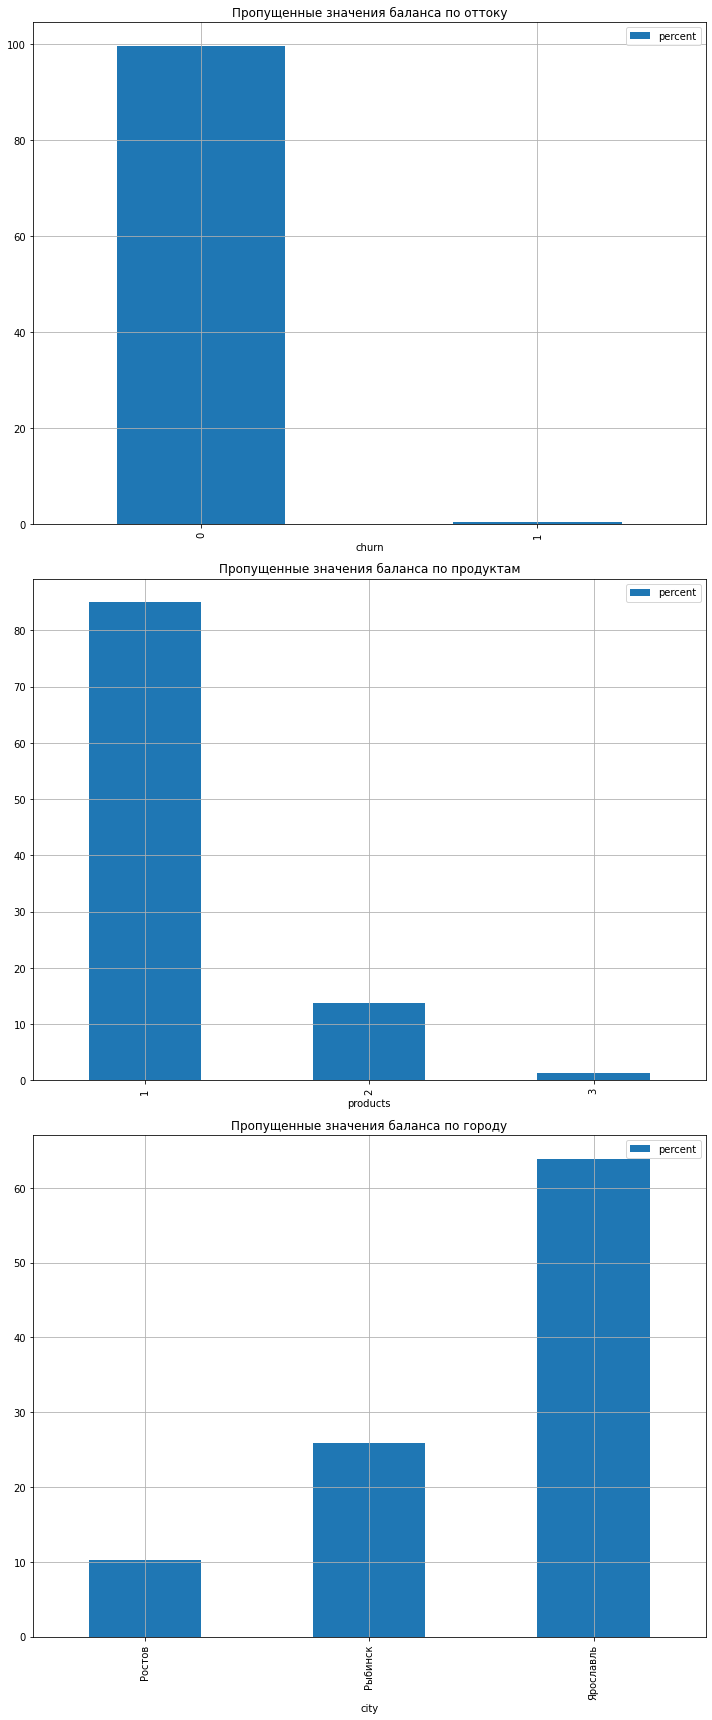

In [14]:
#зададим графики через sublots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 24))

#построим график churn_bar на первой оси
churn_bar.plot(ax=axes[0], x='churn', y='percent', kind='bar', grid=True)
axes[0].set_title('Пропущенные значения баланса по оттоку')

#построим график products_bar на второй оси
products_bar.plot(ax=axes[1], x='products', y='percent', kind='bar', grid=True)
axes[1].set_title('Пропущенные значения баланса по продуктам')

#построим график city_bar на третьей оси
city_bar.plot(ax=axes[2], x='city', y='percent', kind='bar', grid=True)
axes[2].set_title('Пропущенные значения баланса по городу')

#отображаем графики 
plt.tight_layout()
plt.show()


#### Промежуточный вывод

Было проведено исследование причин появления пропусков в столбце balance. 

Обнаружено, что больше всего пропущенных значений находятся в городе Ярославль(>60%), большая часть клиентов с пропусками имеет 1 продукт(>80%), а также практически 100% клиентов с пропущенными значениями являются неушедшими клиентами банка. 

Пропуски в столбце balance могут быть связаны с ошибками банковской системы или некорректным заполнением данных при регистрации клиентов, особенно в городе Ярославль. Также возможно, что данные по балансу на счетах клиентов с одним продуктом не были предоставлены или не были корректно обработаны. Также вероятно, что ошибка возникла при выгрузке информации о неушедших клиентах банка.  

### Обработка дубликатов 

In [15]:
#узнаем количество дубликатов в столбце user_id
pd.DataFrame({'': [data['user_id'].duplicated().sum()]}, index=['Количество дубликатов в столбце "user_id" - '])

,
"Количество дубликатов в столбце ""user_id"" -",73


In [16]:
#попробуем определить закономерность возникновения дубликатов в столбце
duplicated = data[data['user_id'].duplicated()]
duplicated.groupby(['city', 'gender', 'churn'])['user_id'].count().to_frame()

user_id
city      gender churn         
Рыбинск   Ж      0           31
          М      0           10
Ярославль Ж      0            9
          М      0           23

In [17]:
'''
Я очень долго (2 дня) пытался преобразовать дубликаты в 'user_id' таким образом, чтобы только дубликаты были изменены на 
другие значения, это связано с тем, что позже заказчик исследования может искать информацию по датафрейму и сегментам, сопостовляя данные
клиентов по user_id.
В коде ниже у меня получилось это сделать, это не полностью мой код, некоторую информацию я нашел в интернете, но надеюсь это позволительно
Если есть какой то способ сделать это быстрее, пожалуйста, поделись знаниями, буду признателен ! 
'''

users = set()
duplicates = set()

for i, user_id in enumerate(data['user_id']):
    if user_id in users:
        duplicates.add(user_id)
    else:
        users.add(user_id)

for i, user_id in enumerate(data['user_id']):
    if user_id in duplicates:
        data.at[i, 'user_id'] = str(user_id) + str(i)



In [18]:
#преобразуем столбец и приведем его к корректному типу 
data['user_id'] = data['user_id'].astype('int64')       
        
print('Количество дубликатов в столбце "user_id" : ',data['user_id'].duplicated().sum())
print()
display(data.info())


Количество дубликатов в столбце "user_id" :  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


None

#### Промежуточный вывод 

- В столбце 'user_id' обнаружены 73 дубликата, но т.к. в основном датасете после проверки методом duplicated() не было обнаружено ни одного явного дубликата, можно сделать вывод, что данное задвоение ID пользователей вероятно получилось из за некорректной выгрузки данных, было принято решение заменить дубликаты и присвоить новые id пользователям;
- Определенной закономерности в возникновении дубликатов не было обнаружено, но было выявлено, что дубликаты отсутствуют в городе "Ростов", ошибка произошла, возможно, при присоединении данных из этого города, также было обнаружено, что все дубликаты являются неушедшими клиентами банка
____



### Поиск аномальных значений и выбросов

In [19]:
#напишем функцию для отображения выбросов и аномальных значений
def percentile(data, *cols):
    '''
    Функция считает персентиль для каждого необходимого столбца DataFrame
    '''
    result = []
    for col in cols:
        perc = np.nanpercentile(data[col], [10, 25, 50, 75, 90, 95, 99])
        result.append({
            'column': col,
            '10_percentile': round(perc[0], 2),
            '25_percentile': round(perc[1], 2),
            '50_percentile': round(perc[2], 2),
            '75_percentile': round(perc[3], 2),
            '90_percentile': round(perc[4], 2),
            '95_percentile': round(perc[5], 2),
            '99_percentile': round(perc[6], 2)
        })
    return pd.DataFrame(result)

In [20]:
data_percentile = percentile(data, 'score', 'balance', 'est_salary', 'equity', 'age', 'products')
data_percentile

,column,10_percentile,25_percentile,50_percentile,75_percentile,90_percentile,95_percentile,99_percentile
0,score,765.00,802.00,853.0,900.00,928.00,946.00,978.00
1,balance,159201.96,295554.16,524272.2,980705.85,1460133.71,2116704.78,4827443.49
2,est_salary,45471.90,75251.90,119658.1,174500.54,242395.78,316885.34,887903.85
3,equity,0.00,0.00,3.0,4.00,5.00,5.00,7.00
4,age,29.00,33.00,40.0,51.00,61.00,65.00,73.00
5,products,1.00,1.00,2.0,2.00,3.00,3.00,4.00


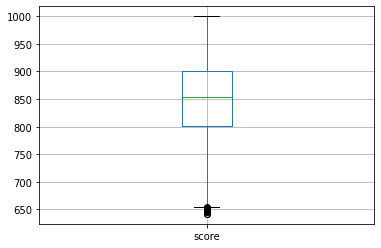

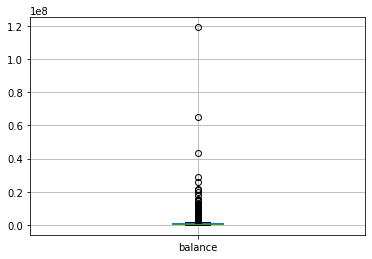

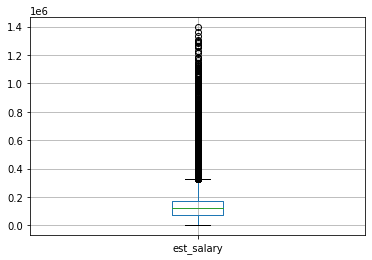

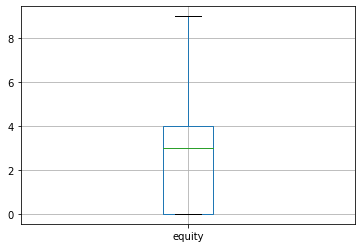

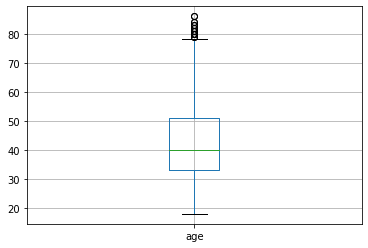

In [21]:
#напишем функцию для отображения графиков сразу в одном note 
def boxplot(data, *cols):
    for col in cols:
        data.boxplot(column=col)
        plt.show()


boxplot(data, 'score', 'balance', 'est_salary', 'equity', 'age')


#####  Для понимания взаимосвязи между выбросами было принято решение проверить корреляцию между столбцами  balance и est_salary

In [22]:
#посчитаем корреляцию данных для столбцов balance и est_salary 
correlation = data['est_salary'].corr(data['balance'])

,est_salary,balance
4005,1395064.45,15624095.80
4637,1363549.52,4054667.81
4473,1333687.36,NaN
1600,1307090.18,NaN
5160,1296838.08,NaN


Корреляция между чистыми данными столбцов составляет: 0.3396218922125886

Корреляция 95% перцентилей данных составляет: 0.4402711417288051


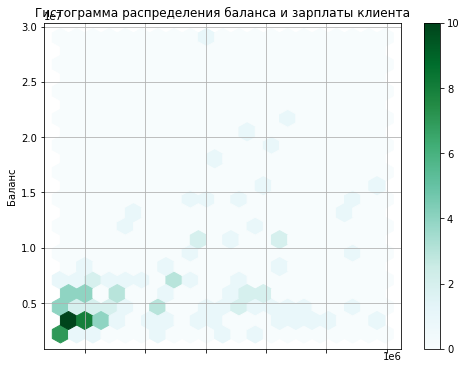

In [23]:
#создадим отдельный датафрейм для анализа взаимосвязи между столбцами est_salary, balance 
est_balance = pd.DataFrame({'est_salary': data.query('est_salary >= 316885')['est_salary'], 'balance': data.query('balance >= 2116704.78')['balance']}).sort_values(by='est_salary', ascending=False)

display(est_balance.head())

correlation_est_balance = est_balance['est_salary'].corr(est_balance['balance'])
print('Корреляция между чистыми данными столбцов составляет:', correlation)
print()
print('Корреляция 95% перцентилей данных составляет:', correlation_est_balance)

est_balance.plot(x='est_salary', y='balance', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)  
plt.title('Гистограмма распределения баланса и зарплаты клиента')
plt.xlabel('Зарплата')
plt.ylabel('Баланс')
plt.show()


In [24]:
#избавимся от выбросов в столбцах 
quantile_est_salary = data['est_salary'].quantile(0.95)
data = data.loc[data['est_salary'] < quantile_est_salary]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9500 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9500 non-null   int64  
 1   score          9500 non-null   float64
 2   city           9500 non-null   object 
 3   gender         9500 non-null   object 
 4   age            9500 non-null   int64  
 5   equity         9500 non-null   int64  
 6   balance        7514 non-null   float64
 7   products       9500 non-null   int64  
 8   credit_card    9500 non-null   int64  
 9   last_activity  9500 non-null   int64  
 10  est_salary     9500 non-null   float64
 11  churn          9500 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 964.8+ KB


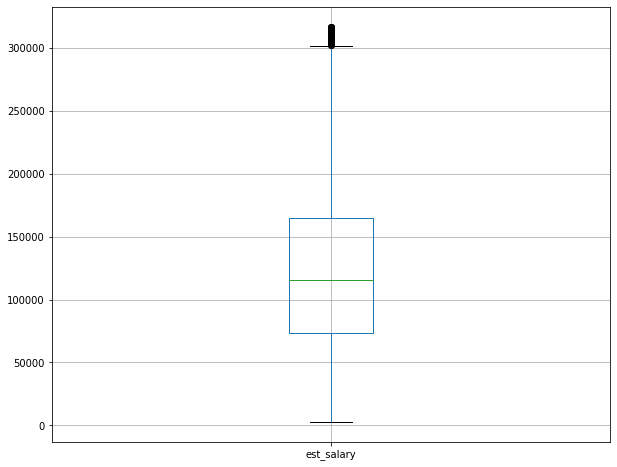

In [25]:
plt.figure(figsize=(10, 8))
boxplot(data, 'est_salary')

#### Промежуточный вывод

Был проведен анализ выбросов в числовых столбцах датафрейма. Из него вытекают следующие выводы: 

- В столбцах score, age, equity выбросы не обнаружены
- Не смотря на то, что выбросы в equity не обнаружены, 95й процентиль составляет всего 5 объектов собственности, при сокращении выбросов мы можем потерять большое количество данных, поэтому принимаем решение в будущих исследованиях оставить максимальное количество объектов - 5.
- Не смотря на то, что выбросы в products не обнаружены, 95й процентиль составляет всего 3 продукта банка, при сокращении выбросов мы можем потерять большое количество данных, поэтому принимаем решение в будущих исследованиях оставить максимальное количество продуктов - 3. 
- В столбце balance наблюдаются пропущенные значения. Из-за их наличия, удаление выбросов из столбца может существенно повлиять на исходный датасет. Также следует учитывать, что отсутствие данных в столбце может стать причиной некорректных результатов анализа.
- Для столбца est_salary было принято решение удалить значения выше 95-го процентиля.
- Было проведено дополнительное исследование корреляции между данными в столбцах balance и est_salary для возможного заполнения столбца balance значениями связанными с est_salary, но исследование выявило среднюю корреляцию данных, которая в большей степени проявляется при высоких значениях, что не дает такой возможности.
____

### Вывод Шаг 2. 

По окончанию предобработки данных были получены следующие результаты:  

- Данные были приведены к удобному для исследования формату;
- Пропуски столбца 'age' обработаны, столбец приведен к корректному типу данных;
- Обработка пропусков столбца 'balance'приведет к искажению результатов анализа, поэтому было приятно решение оставить их без изменений;
- В столбце 'user_id' обнаружены 73 дубликата, но т.к. в основном датасете после проверки методом duplicated() не было обнаружено ни одного явного дубликата, можно сделать вывод, что данное задвоение ID пользователей вероятно получилось из за некорректной выгрузки данных, было принято решение заменить дубликаты и присвоить новые id пользователям;
- Определенной закономерности в возникновении дубликатов не было обнаружено, но было выявлено, что дубликаты отсутствуют в городе "Ростов", ошибка произошла, возможно, при присоединении данных из этого города, также было обнаружено, что все дубликаты являются неушедшими клиентами банка; 

Был проведен анализ выбросов в числовых столбцах датафрейма. Из него вытекают следующие выводы: 

- В столбцах score, age, equity выбросы не обнаружены;
- Не смотря на то, что выбросы в equity не обнаружены, 95й процентиль составляет всего 5 объектов собственности, при сокращении выбросов мы можем потерять большое количество данных, поэтому принимаем решение в будущих исследованиях оставить максимальное значение объектов - 5. 
- Не смотря на то, что выбросы в products не обнаружены, 95й процентиль составляет всего 3 продукта банка, при сокращении выбросов мы можем потерять большое количество данных, поэтому принимаем решение в будущих исследованиях оставить максимальное количество продуктов - 3. 
- В столбце balance наблюдаются пропущенные значения. Из-за их наличия, удаление выбросов из столбца может существенно повлиять на исходный датасет. Также следует учитывать, что отсутствие данных в столбце может стать причиной некорректных результатов анализа.
- Для столбца est_salary было принято решение удалить значения выше 95-го квантиля.
- Было проведено дополнительное исследование корреляции между данными в столбцах balance и est_salary, который выявил среднюю корреляцию данных, которая в большей степени проявляется при высоких значениях.

___
___


## Шаг 3. Исследовательский анализ данных 

В этом блоке исследования необходимо провести исследование данных по разным категориям и проанализировать полученные данные. 


- Оценить, подсчитать и отобразить на графике распределение данных по столбцам;  
- 
        A) Добавить новый столбец с категориями кредитного скорринга для дальнейшего расчета оттока клиентов по категориям рейтинга
        B) Добавить новый столбец с возрастными категориями для дальнейшего расчета оттока клиентов по категориям 
        C) Проверить: равномерно ли распределены данные по городам, категориям кредитного рейтинга и возрастным категориям
        D) Проверить распределение в числовых столбцах 
  
 
- Создать dummies-столбцы для данных 'city', а также изменить данные столбца gender обозначив 1 - Мужчины, 0 - Женщины для корректного постороения таблицы корреляции
- Построить тепловую карту корреляции для определения взаимосвязей данных столбцов со столбцом churn, характеризующий отток клиентов;
- Провести исследование в каких городах отток клиентов больше;
- Провести исследование в какой возрастной категории отток клиентов больше и построить матрицу корреляции оттока клиентов и возраста клиента;
- Провести исследование в банках с какой категорией рейтинга и с каким именно рейтингом отток клиентов больше;
- Провести исследование и проверить отток по гендерному признаку;
- Провести исследование и проверить зависимость наличия карты у клиента и оттока клиентов;
- Провести исследование и проверить зависимость активности клиента и его оттока;
- Провести исследование и проверить зависимость количества продуктов у клиента и оттока;
- Провести исследование и проверить зависимость количества объектов собственности у клиента и оттока;
- Провести исследование и построить матрицу корреляции зарплаты и оттока клиентов с помощью матрицы корреляции;
- Провести исследование и проверить зависимость баланса клиента и его оттока;
- Описать выводы и закономерности в исходных данных, определить сегменты для проведения анализа оттока; 


____

### Добавление новых категорий и проверка распределения 

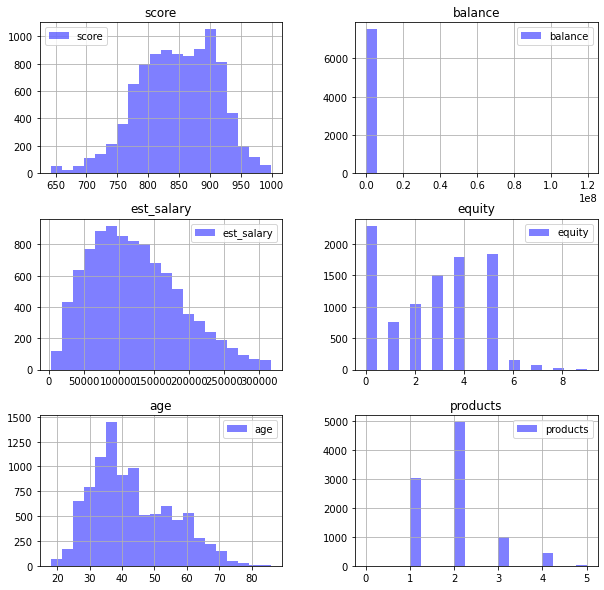

In [26]:
#посмотрим распределение данных в числовых столбцах

data[['score', 'balance', 'est_salary', 'equity', 'age', 'products']].hist(alpha=0.5, figsize = (10, 10), bins = 20, legend=True, color='blue')
plt.show()

In [27]:
def score_group(score):
    """
    Возвращает категорию рейтинга по значению 'score', используя правила:
    - 1 – 710 баллов: очень низкий, получить кредит практически невозможно.
    - 711 – 808 баллов: средний, получить деньги будет непросто.
    - 809 – 890 баллов: хороший, получить заем будет легко.
    - 891 – 999 баллов: очень хороший, банки выстраиваются в очередь со своими предложениями.
    информация с сайта(https://sovcombank.ru/blog/krediti/chto-takoe-kreditnii-reiting)
    """
    
    if score <= 710:
        return 'низкий'
    if score > 710 and score <= 808:
        return 'средний'
    if score > 808 and score <= 890:
        return 'хороший'
    return 'очень хороший' 

In [28]:
def age_group(age):
    """
    Возвращает категорию возраста по значению 'age', используя правила:
    - 18-35: клиенты молодого возраста
    - 35-55: клиенты среднего возраста
    - >55: клиенты старшего возраста
    """
    
    if age <= 35:
        return 'клиенты молодого возраста'
    if age > 35 and age <= 55:
        return 'клиенты среднего возраста'
    return 'клиенты старшего возраста' 

In [29]:
#применим функцию и добавим новый столбец
data['score_group'] = data['score'].apply(score_group)
data['age_group'] = data['age'].apply(age_group)
data.sample(3)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_group,age_group
8061,154869,869.0,Рыбинск,Ж,37,4,925384.79,2,1,0,115765.41,0,хороший,клиенты среднего возраста
2569,228051,884.0,Ярославль,М,52,5,1000412.33,4,0,0,147544.50,0,хороший,клиенты среднего возраста
4643,188381,872.0,Рыбинск,Ж,38,4,420432.93,2,0,0,31159.45,0,хороший,клиенты среднего возраста


,score_group,count,percent
0,хороший,4068,42.82
1,очень хороший,2732,28.76
2,средний,2474,26.04
3,низкий,226,2.38


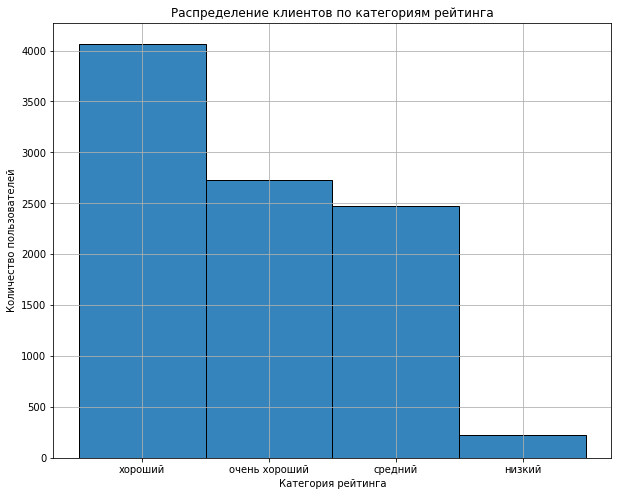

In [30]:
#создаем датафрейм score_group
score_group = data['score_group'].value_counts().to_frame().reset_index()
score_group.columns = ['score_group', 'count']
score_group['percent'] = (score_group['count'] / len(data) *100).round(2)
display(score_group)
#посморим распределение рейтингов 
plt.figure(figsize=(10, 8))
sns.histplot(data=data, x='score_group', alpha=0.9,  palette="Paired")
plt.grid(True)
plt.title('Распределение клиентов по категориям рейтинга')
plt.xlabel('Категория рейтинга')
plt.ylabel('Количество пользователей')
plt.show()

,age_group,count,percent
0,клиенты среднего возраста,4615,48.58
1,клиенты молодого возраста,3136,33.01
2,клиенты старшего возраста,1749,18.41


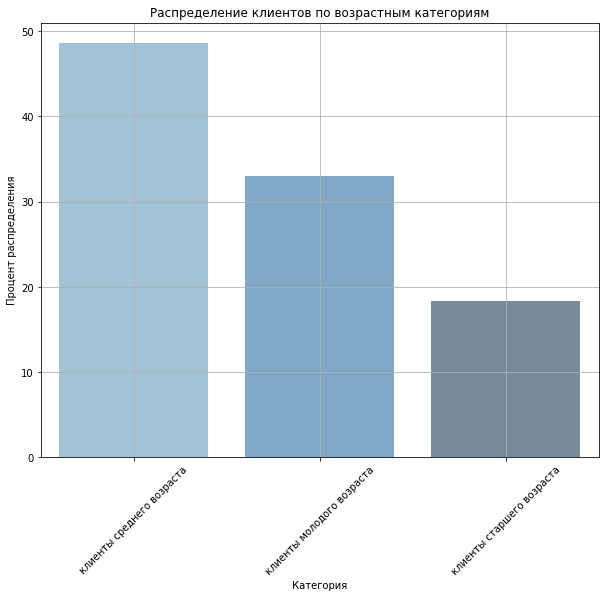

In [31]:
#создаем датафрейм age_group
age_group = data['age_group'].value_counts().to_frame().reset_index()
age_group.columns = ['age_group', 'count']
age_group['percent'] = (age_group['count'] / len(data) *100).round(2)
display(age_group)
#посморим распределение возрастных групп 
plt.figure(figsize=(10, 8))
sns.barplot(data=age_group, x='age_group', y='percent', alpha=0.7,  palette="Blues_d")
plt.title('Распределение клиентов по возрастным категориям')
plt.xlabel('Категория')
plt.ylabel('Процент распределения')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

,city,count
0,Ростов,1397
1,Рыбинск,2593
2,Ярославль,5510


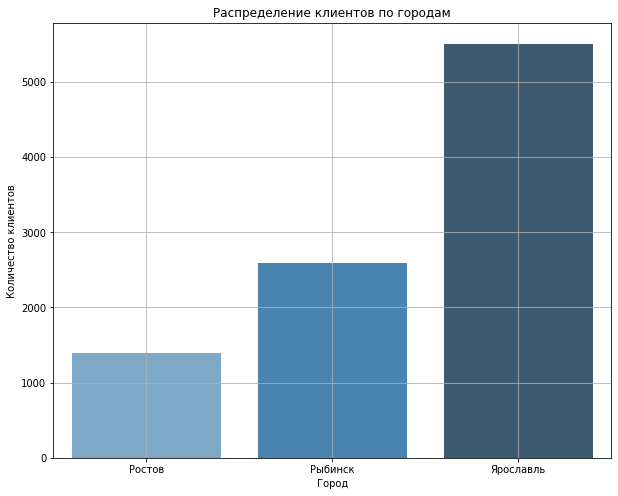

In [32]:
#построим график распределения значений по городам
city_df = data['city'].value_counts().to_frame().reset_index()
city_df = city_df.rename(columns = {'index':'city', 'city': 'count'})
city_df = city_df.sort_values(by='count').reset_index(drop=True)

display(city_df)

plt.figure(figsize=(10, 8))
sns.barplot(x=city_df.city, y='count', data=city_df, palette="Blues_d")
plt.title('Распределение клиентов по городам')
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

#### Промежуточный вывод

- В столбцах products, equity, score данные имеют нормальное распределение; 
- В столбце age, est_salary график отноняется вправо по оси Х, что означает - данные имеют асимметричное распределение. Скошенность вправо указывает на наличие выбросов или аномалий среди более высоких значений, которые могут повлиять на анализ и интерпретацию данных, рекомендуется учитывать это при дальнейшем анализе данных;
- Столбец balance имеет большую аномальную часть значений, но мы будем учитывать их в дальнейшем анализе. 
- Больше всего значений в категории рейтинга "Хороший" (809 – 890 баллов), примерно равное количество в категории "Очень хороший" (891 – 999 баллов) и "Средний" (711 – 808 баллов), практически отсутсвует категория "Низкий" рейтинг (1 – 710 баллов), что делает затруднительным дальнейший анализ по категориям рейтинга и проверка гипотезы "Клиенты с более низким рейтингом в большей степени являются уходящими клиентами банка"
- Больше всего значений возрастной категории "Среднего возраста" (4615 пользователей) , затем "Клиенты молодого возраста" (3136 пользователей) и "Клиенты старшего возраста" (1749 пользователей); 
- Данные по городам распределены неравномерно, больше всего значений в городе "Ярославль", меньше всего в городе "Ростов", что также может влиять на результы исследования, но не в большой степени
___

### Построение тепловой карты корреляции для определения взаимосвязей данных

In [33]:
#заменим данные столбца gender обозначив 1 - Мужчины, 0 - Женщины для корректного постороения таблицы корреляции
data['gender'] = data['gender'].replace({'М': 1, 'Ж': 0})
data.sample(3)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_group,age_group
6507,117047,775.0,Рыбинск,1,53,0,334680.20,2,1,1,100132.52,0,средний,клиенты среднего возраста
4708,145234,931.0,Ярославль,1,58,0,NaN,1,1,1,104945.74,0,очень хороший,клиенты старшего возраста
4129,218630,830.0,Ярославль,1,25,4,309152.85,2,1,0,74847.45,0,хороший,клиенты молодого возраста


In [34]:
#создадим дубликат столбца city потому что по какой то причине drop_first=False не работает и удаляет столбец city 
data = data.assign(city_copy = data['city'])
#методом get_dummies выделим 3 отдельных столбца городов для анализа корреляции 
data = pd.get_dummies(data, columns=['city_copy'], drop_first=False)
data = data.rename(columns={'city_copy_Ростов' : 'city_rostov', 'city_copy_Рыбинск':'city_rybinsk', 'city_copy_Ярославль':'city_yaroslavl'})

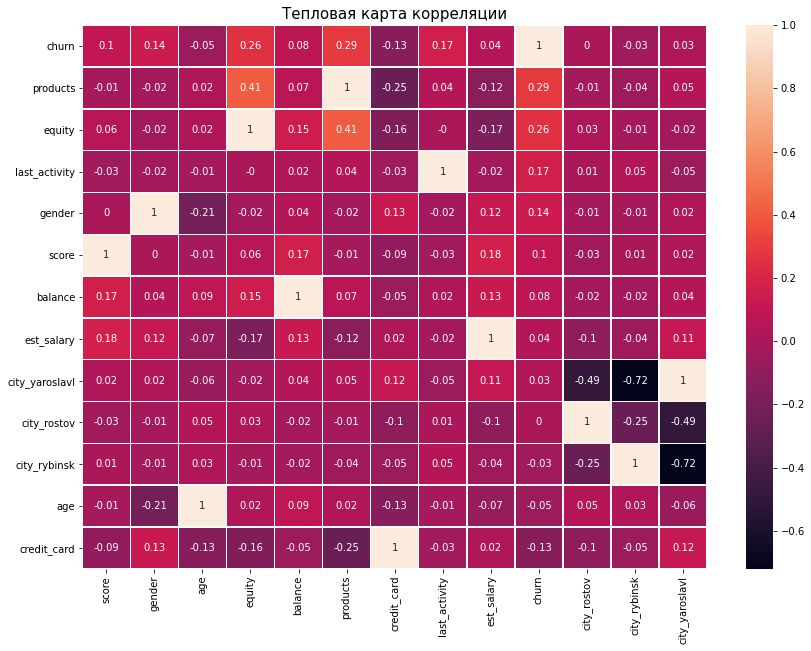

In [35]:
#создадим тепловую карту для исследования 
data_corr = data.drop('user_id', axis=1).corr().round(2).sort_values(by='churn', ascending=False)
custom_palette = sns.color_palette("rocket", as_cmap=True)
plt.figure(figsize=(14, 10))
ax = sns.heatmap(data_corr, annot=True, linewidth=0.5, cmap=custom_palette)
ax.set_title('Тепловая карта корреляции', fontsize=15)
plt.show()

#### Промежуточный вывод

- Были изменены данные столбца gender и присвоены значения: 1 - Мужчины, 0 - Женщины для корректного постороения таблицы корреляции;
- Функцией get_dummies было выделено 3 отдельных столбца городов для анализа корреляции;
- Тепловая карта корреляции для определения взаимосвязи между данными столбцов датасета и столбца churn показала следующие результаты:
        - Средняя Взаимосвязь наблюдается столбца churn наблюдается с столбцами "equity", "products", "last_activity";
        - Менее значительные показатели взаимосвязи, наблюдаются с столбцами "gender", "credit_card"
        - В остальных столбцах тепловая карта корреляции не показала взаимосвязи со столбцом churn.
- Отдельно от столбца churn наблюдается взаимосвязь между столбцами "equity" и "products", а также обратная взаимосвязь между городами: "при увеличении клиентов в одном городе уменьшается количество клиентов в другом", что логично. 

___

### Исследование взаимосвязи городов и оттока клиентов 

Данные полученные из тепловой карты корреляции показали, что взаимосвязи между городами и уходом клиентов практически нет и все же необходимо дополнительное исследование для выстраивания дальнейшего анализа на основе данных 

Проверка столбца city показала, что распределение значений неравное, это означает, что для правильного определения оттока клиентов необходимо ориентироваться на относительные показатели, а не абсолютные


,city,total,churn_0,churn_1,percent_0,percent_1
0,Ростов,1397,1138,259,81.46,18.54
1,Рыбинск,2593,2168,425,83.61,16.39
2,Ярославль,5510,4456,1054,80.87,19.13


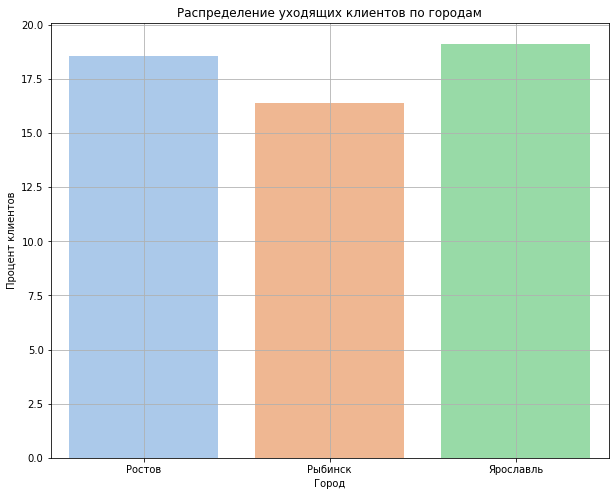

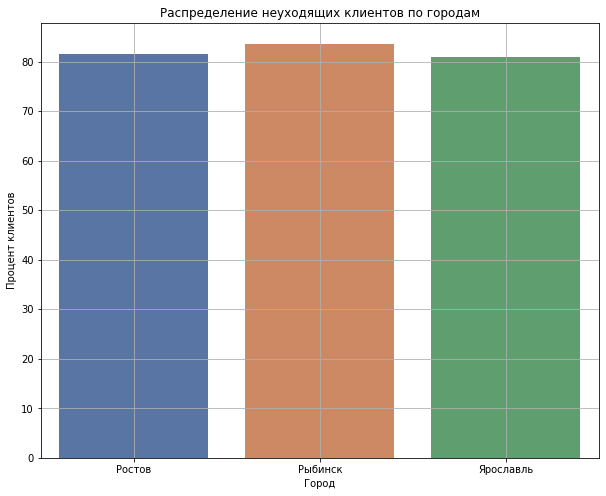

In [36]:
# создаем сводную таблицу с подсчетом churn 0 и churn 1 для каждого города
churn_city = data.pivot_table(index='city', columns='churn', values='user_id', aggfunc='count').reset_index()

# присоединяем таблицу city_df по наименованию города
churn_city = churn_city.merge(city_df, on='city')

#меняем названия колонок
churn_city.columns = ['city', 'churn_0', 'churn_1', 'total']

# считаем процент churn 0 и churn 1 для каждого города
churn_city['percent_0'] = (churn_city['churn_0'] / churn_city['total'] * 100).round(2)
churn_city['percent_1'] = (churn_city['churn_1'] / churn_city['total'] * 100).round(2)

# меняем порядок столбцов
cols = churn_city.columns.tolist()
cols.insert(1, cols.pop(3))
churn_city = churn_city[cols]

display(churn_city)

# строим график для churn 1
plt.figure(figsize=(10, 8))
sns.barplot(x='city', y='percent_1', data=churn_city, palette="pastel")
plt.title('Распределение уходящих клиентов по городам')
plt.xlabel('Город')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
sns.barplot(x='city', y='percent_0', data=churn_city, palette="deep")
plt.title('Распределение неуходящих клиентов по городам')
plt.xlabel('Город')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


#### Промежуточный вывод

- Больший отток клиентов наблюдается в городе "Ярославль", это может быть связано с большим количеством клиентов в данном городе, а меньше всего отток в городе "Рыбинск", в дальнейшем исследовании можно учесть этот показатель для ; 
- Неуходящие клиенты банка распределены равномерно между городами.

___

### Исследование взаимосвязи возраста и оттока клиентов и матрица корреляции

,age_group,total,churn_0,churn_1,percent_0,percent_1
0,клиенты молодого возраста,3136,2474,662,78.89,21.11
1,клиенты среднего возраста,4615,3809,806,82.54,17.46
2,клиенты старшего возраста,1749,1479,270,84.56,15.44


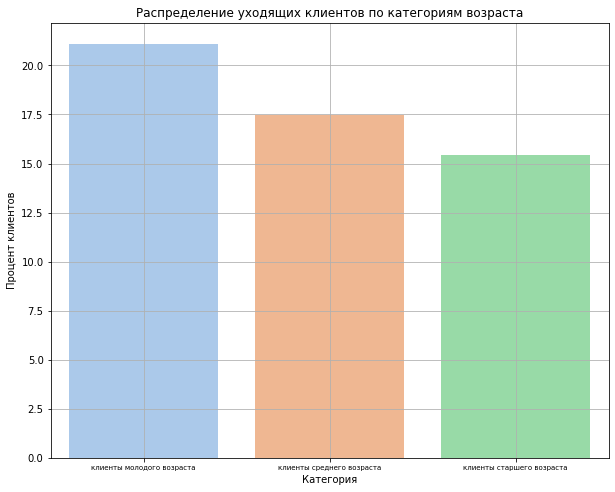

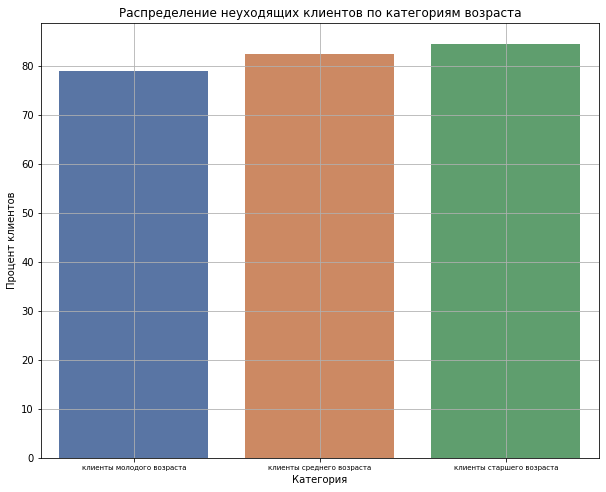

In [37]:
#создадим сводную таблицу с категориями
data_age = data.pivot_table(index='age_group', columns='churn', values='user_id', aggfunc='count').reset_index()
data_age = data_age.merge(age_group.drop('percent', axis=1), on='age_group')
data_age.columns = ['age_group', 'churn_0', 'churn_1', 'total']

# считаем процент churn 0 и churn 1 для каждого города
data_age['percent_0'] = (data_age['churn_0'] / data_age['total'] * 100).round(2)
data_age['percent_1'] = (data_age['churn_1'] / data_age['total'] * 100).round(2)

# меняем порядок столбцов
cols = data_age.columns.tolist()
cols.insert(1, cols.pop(3))
data_age = data_age[cols]

display(data_age)
# строим график для churn 0

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='age_group', y='percent_1', data=data_age, palette="pastel")
plt.title('Распределение уходящих клиентов по категориям возраста')
plt.xlabel('Категория')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='age_group', y='percent_0', data=data_age, palette="deep")
plt.title('Распределение неуходящих клиентов по категориям возраста')
plt.xlabel('Категория')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()



,age,churn_0,churn_1
0,18,12.0,1.0
1,19,15.0,1.0
2,20,20.0,3.0
3,21,11.0,4.0
4,22,23.0,4.0
...,...,...,...
63,81,4.0,NaN
64,82,2.0,NaN
65,83,3.0,NaN
66,84,2.0,NaN


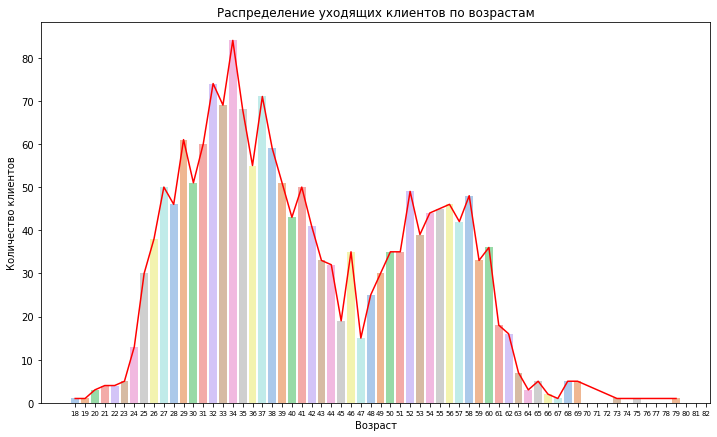

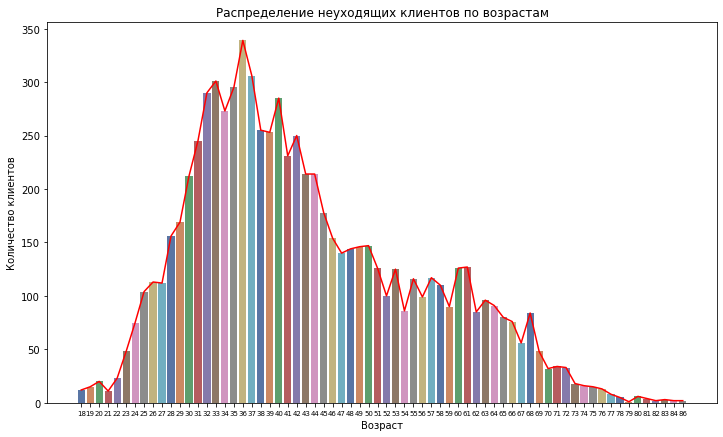

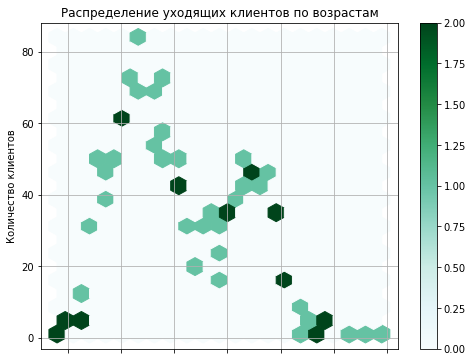

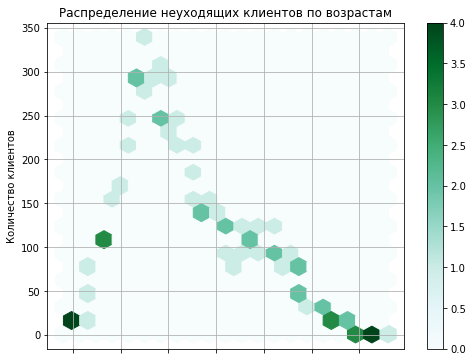

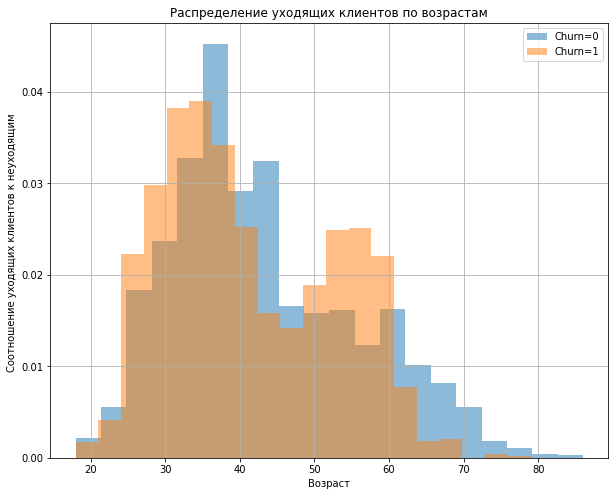

In [38]:
#создадим сводную таблицу с возрастом
churn_age = data.pivot_table(index='age', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_age.columns = ['age', 'churn_0', 'churn_1']
churn_age = churn_age.sort_values(by='age')

display(churn_age)

# строим график для churn 1 с линией вдоль столбцов
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='age', y='churn_1', data=churn_age, palette="pastel")
sns.lineplot(x=churn_age.index, y='churn_1', data=churn_age, color='red', ax=ax)
plt.title('Распределение уходящих клиентов по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим график для churn 0 с линией вдоль столбцов
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='age', y='churn_0', data=churn_age, palette="deep")
sns.lineplot(x=churn_age.index, y='churn_0', data=churn_age, color='red', ax=ax)
plt.title('Распределение неуходящих клиентов по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим гексагональную диаграмму для churn 1
churn_age.plot(x='age', y='churn_1', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)  
plt.title('Распределение уходящих клиентов по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

# строим гексагональную диаграмму для churn 0
churn_age.plot(x='age', y='churn_0', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)  
plt.title('Распределение неуходящих клиентов по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()


# построение гистограммы возраста с параметром density=True
plt.figure(figsize=(10, 8))
plt.hist(data.age[data.churn == 0], bins=20, alpha=0.5, label='Churn=0', density=True)
plt.hist(data.age[data.churn == 1], bins=20, alpha=0.5, label='Churn=1', density=True)
plt.title('Распределение уходящих клиентов по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Соотношение уходящих клиентов к неуходящим ')
plt.grid(True)
plt.legend()
plt.show()



#### Промежуточный вывод


- Отличительно больший отток происходит у клиентов молодого возраста;
- Неуходящие клиенты распределены нормально по всем категориям; 
- При более подробном исследовании сегмента было обнаружено 2 пика по количеству уходящих клиентов:
        - Клиенты молодого и среднего возраста от 28 до 44 лет;
        - Клиенты старшего возраста от 49 до 60 лет; 
- Матрица распределения также указывает на большое количество значений в данных областях;
- Больше всего неуходящих клиентов приходится на средний возраст клиентов от 35 лет.

___


###  Исследование взаимосвязи рейтингов банка и оттока клиентов 

In [39]:
plt.figure(figsize=(10, 5))

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

,score_group,total,churn_0,churn_1,percent_0,percent_1
0,низкий,226,224,2,99.12,0.88
1,очень хороший,2732,2239,493,81.95,18.05
2,средний,2474,2205,269,89.13,10.87
3,хороший,4068,3094,974,76.06,23.94


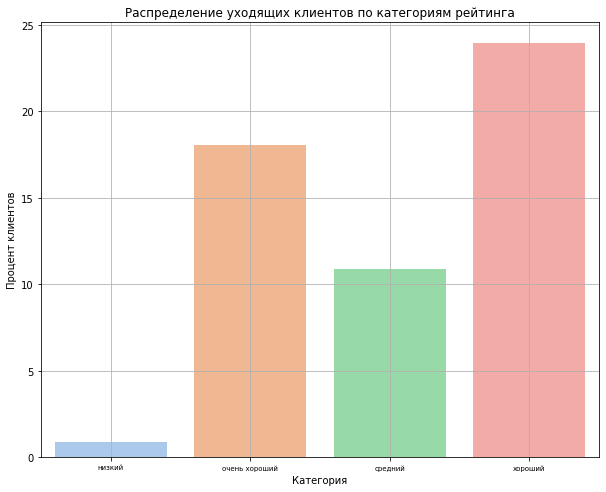

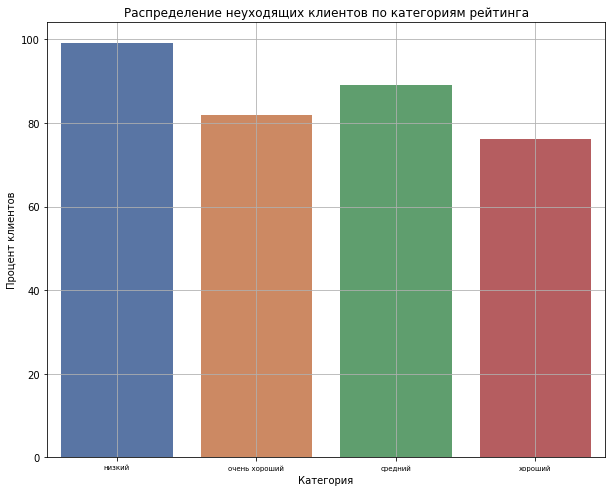

In [40]:
#создадим сводную таблицу с категориями рейтингов 
data_score = data.pivot_table(index='score_group', columns='churn', values='user_id', aggfunc='count').reset_index()
data_score = data_score.merge(score_group.drop('percent', axis=1), on='score_group')
data_score.columns = ['score_group', 'churn_0', 'churn_1', 'total']

# считаем процент churn 0 и churn 1
data_score['percent_0'] = (data_score['churn_0'] / data_score['total'] * 100).round(2)
data_score['percent_1'] = (data_score['churn_1'] / data_score['total'] * 100).round(2)

# меняем порядок столбцов
cols = data_score.columns.tolist()
cols.insert(1, cols.pop(3))
data_score = data_score[cols]

display(data_score)

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='score_group', y='percent_1', data=data_score, palette="pastel")
plt.title('Распределение уходящих клиентов по категориям рейтинга')
plt.xlabel('Категория')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='score_group', y='percent_0', data=data_score, palette="deep")
plt.title('Распределение неуходящих клиентов по категориям рейтинга')
plt.xlabel('Категория')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()



,score,churn_0,churn_1
0,642.0,2.0,NaN
1,646.0,2.0,NaN
2,648.0,2.0,NaN
3,649.0,7.0,NaN
4,650.0,2.0,NaN
...,...,...,...
342,995.0,1.0,NaN
343,996.0,2.0,NaN
344,997.0,2.0,NaN
345,998.0,1.0,NaN


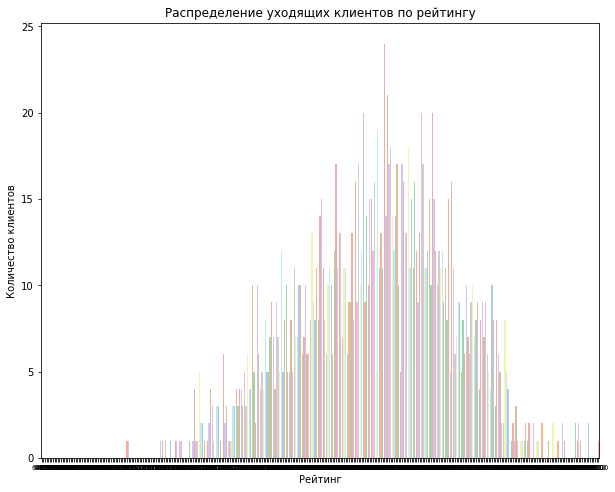

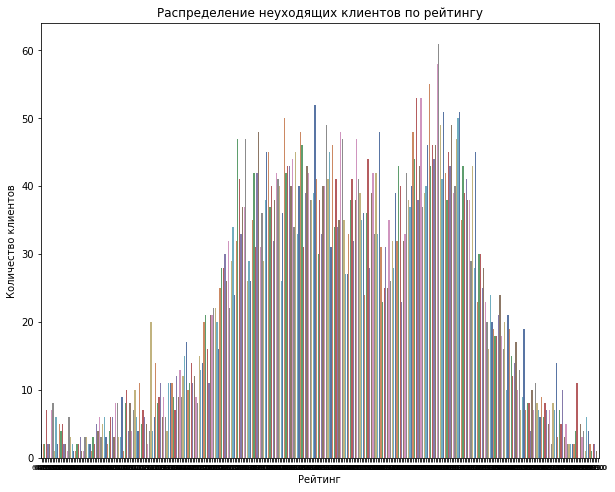

<Figure size 720x576 with 0 Axes>

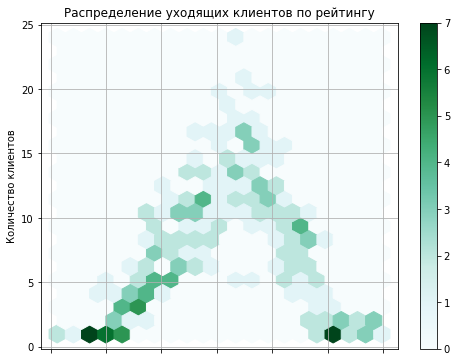

<Figure size 720x576 with 0 Axes>

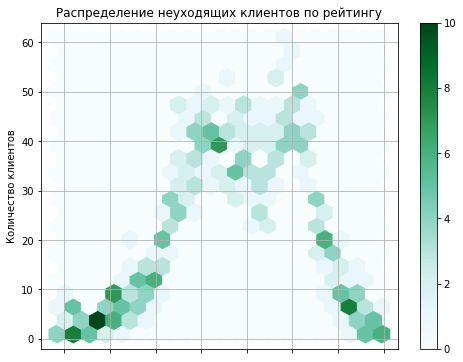

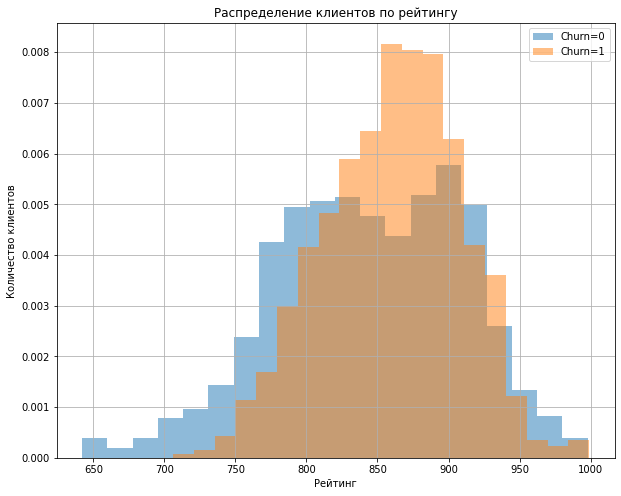

In [41]:
#создадим сводную таблицу с подробным рейтингом
churn_score = data.pivot_table(index='score', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_score.columns = ['score', 'churn_0', 'churn_1']
churn_score = churn_score.sort_values(by='score')

display(churn_score)

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='score', y='churn_1', data=churn_score, palette="pastel", ci=10)
plt.title('Распределение уходящих клиентов по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='score', y='churn_0', data=churn_score, palette="deep")
plt.title('Распределение неуходящих клиентов по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим гексагональную диаграмму для churn 1
plt.figure(figsize=(10, 8))
churn_score.plot(x='score', y='churn_1', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True) 
plt.title('Распределение уходящих клиентов по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Количество клиентов')
plt.show()

# строим гексагональную диаграмму для churn 0
plt.figure(figsize=(10, 8))
churn_score.plot(x='score', y='churn_0', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)
plt.title('Распределение неуходящих клиентов по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Количество клиентов')
plt.show()


# построение гистограммы рейтинга с параметром density=True
plt.figure(figsize=(10, 8))
plt.hist(data.score[data.churn == 0], bins=20, alpha=0.5, label='Churn=0', density=True)
plt.hist(data.score[data.churn == 1], bins=20, alpha=0.5, label='Churn=1', density=True)
plt.title('Распределение клиентов по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Количество клиентов')
plt.grid(True)
plt.legend()
plt.show()



#### Промежуточный вывод


- Отличительно больший отток происходит у клиентов категории рейтинга "Хороший" и "Очень хороший";
- Неуходящих клиентов больше всего в категории рейтинга "Низкий", но т.к. эта категория очень незначительная ее нельзя брать во внимание, а меньше всего в категориях рейтинга "Хороший" и "Очень хороший"; 
- При более подробном исследовании сегмента было обнаружен пик по количеству уходящих клиентов:
        - Клиенты категории рейтинга "Хороший" и рейтингом от 850 до 900;
- Матрица распределения также указывает на большое количество значений в данных областях, а также распределение уходящих клиентов в категории "Низкий", и "Очень хороший";

____


###  Исследование взаимосвязи гендерного признака и оттока клиентов 

,gender,churn_0,churn_1,total,percent_0,percent_1
0,1,3582,1121,4703,76.16,23.84
1,0,4180,617,4797,87.14,12.86


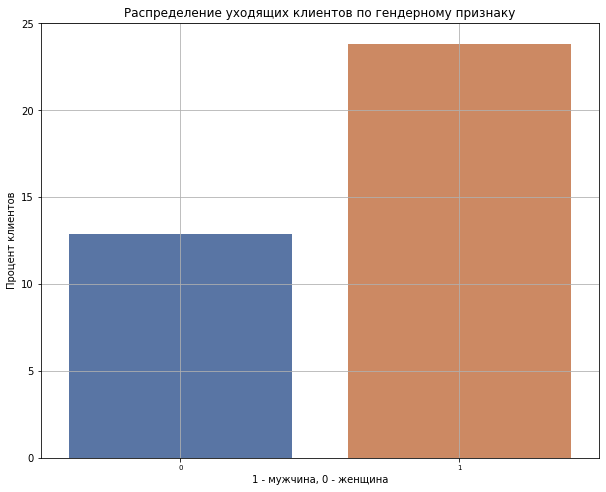

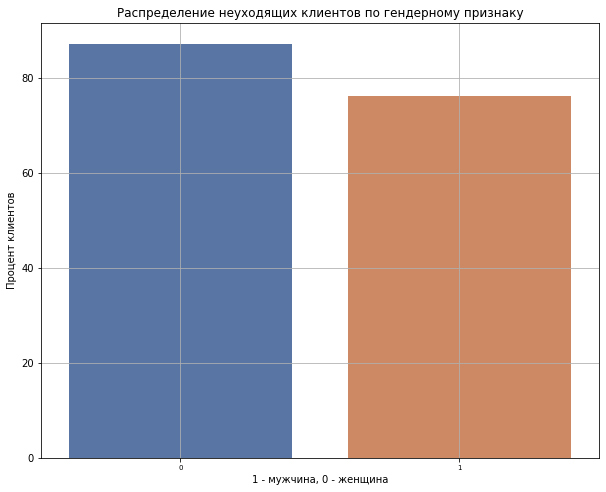

In [42]:
# создаем сводную таблицу с подсчетом churn 0 и churn 1 для каждого гендера
churn_gender = data.pivot_table(index='gender', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_gender.columns = ['gender', 'churn_0', 'churn_1']
churn_gender = churn_gender.sort_values(by='churn_1', ascending=False)
churn_gender = churn_gender.reset_index(drop=True)
churn_gender['total'] = churn_gender['churn_1'] + churn_gender['churn_0']
churn_gender['percent_0'] = (churn_gender['churn_0'] / churn_gender['total'] *100).round(2)
churn_gender['percent_1'] = (churn_gender['churn_1'] / churn_gender['total'] *100).round(2)

display(churn_gender)

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='gender', y='percent_1', data=churn_gender, palette="deep")
plt.title('Распределение уходящих клиентов по гендерному признаку')
plt.xlabel('1 - мужчина, 0 - женщина')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='gender', y='percent_0', data=churn_gender, palette="deep")
plt.title('Распределение неуходящих клиентов по гендерному признаку')
plt.xlabel('1 - мужчина, 0 - женщина')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()




#### Промежуточный вывод

- Практически в 2 раза больше отток клиентов мужчин; 
- Больше всего неуходящих клиентов - женщин. 


____

### Исследование взаимосвязи наличия карты и оттока клиентов 

,credit_card,churn_0,churn_1,total,percent_0,percent_1
0,1,5481,958,6439,85.12,14.88
1,0,2281,780,3061,74.52,25.48


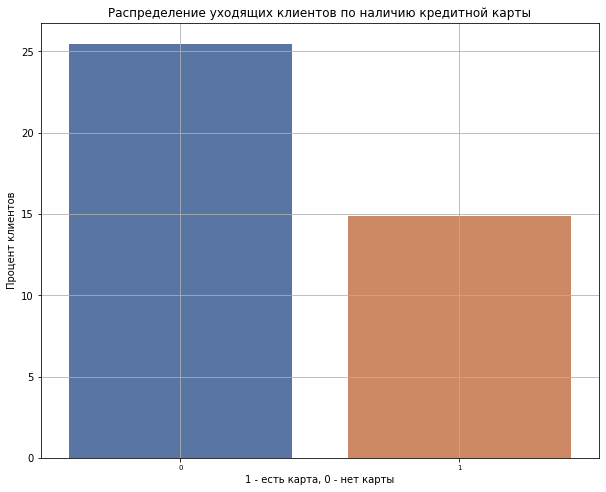

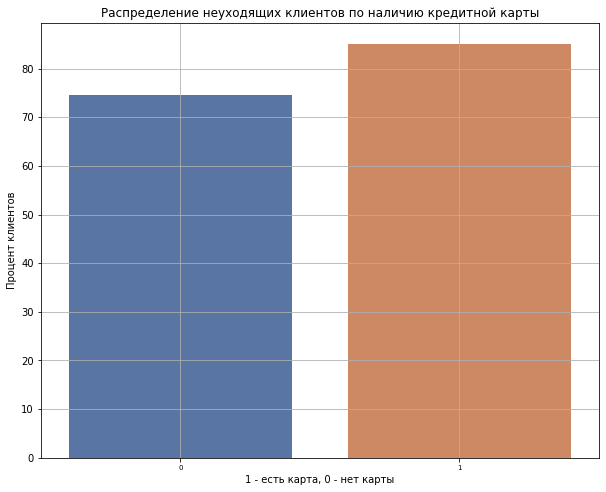

In [43]:
# создаем сводную таблицу с подсчетом churn 0 и churn 1 для каждого обладателя карты
churn_card = data.pivot_table(index='credit_card', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_card.columns = ['credit_card', 'churn_0', 'churn_1']
churn_card = churn_card.sort_values(by='churn_1', ascending=False)
churn_card = churn_card.reset_index(drop=True)
churn_card['total'] = churn_card['churn_1'] + churn_card['churn_0']
churn_card['percent_0'] = (churn_card['churn_0'] / churn_card['total'] *100).round(2)
churn_card['percent_1'] = (churn_card['churn_1'] / churn_card['total'] *100).round(2)

display(churn_card)

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='credit_card', y='percent_1', data=churn_card, palette="deep")
plt.title('Распределение уходящих клиентов по наличию кредитной карты')
plt.xlabel('1 - есть карта, 0 - нет карты')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='credit_card', y='percent_0', data=churn_card, palette="deep")
plt.title('Распределение неуходящих клиентов по наличию кредитной карты')
plt.xlabel('1 - есть карта, 0 - нет карты')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()




#### Промежуточный вывод

- Отток происходит в большей степени у клиентов без кредитной карты;
- Неуходящих клиентов с кредитной карты больше, чем без неё.

____

### Исследование взаимосвязи активности клиента и оттока 

,last_activity,churn_0,churn_1,total,percent_0,percent_1
0,1,3740,1210,4950,75.56,24.44
1,0,4022,528,4550,88.40,11.60


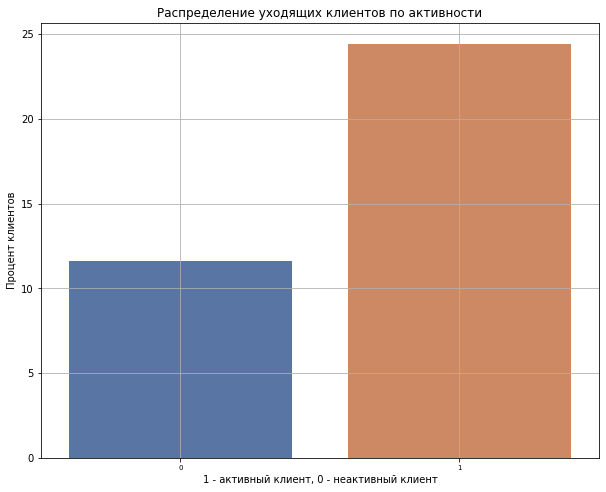

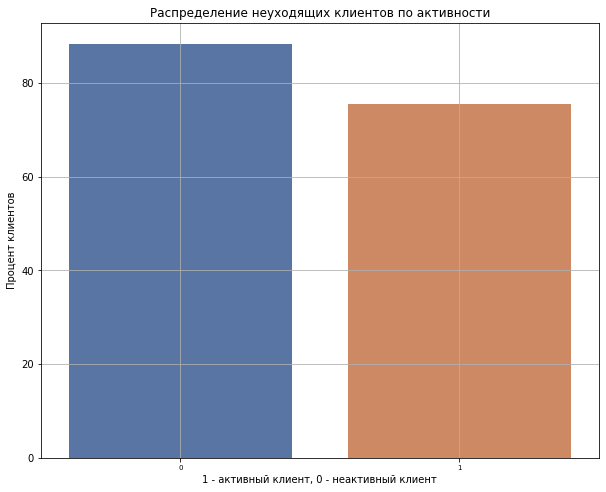

In [44]:
# создаем сводную таблицу с подсчетом churn 0 и churn 1 по активности клиента 
churn_activity = data.pivot_table(index='last_activity', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_activity.columns = ['last_activity', 'churn_0', 'churn_1']
churn_activity = churn_activity.sort_values(by='churn_1', ascending=False)
churn_activity = churn_activity.reset_index(drop=True)
churn_activity['total'] = churn_activity['churn_1'] + churn_activity['churn_0']
churn_activity['percent_0'] = (churn_activity['churn_0'] / churn_activity['total'] *100).round(2)
churn_activity['percent_1'] = (churn_activity['churn_1'] / churn_activity['total'] *100).round(2)

display(churn_activity)

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='last_activity', y='percent_1', data=churn_activity, palette="deep")
plt.title('Распределение уходящих клиентов по активности')
plt.xlabel('1 - активный клиент, 0 - неактивный клиент')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='last_activity', y='percent_0', data=churn_activity, palette="deep")
plt.title('Распределение неуходящих клиентов по активности')
plt.xlabel('1 - активный клиент, 0 - неактивный клиент')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.grid(True)
plt.show()




#### Промежуточный вывод

- В большей степени отток клиентов происходит у активных клиентов, вероятно это связано с фиксированием каких либо действий перед уходом;
- Неуходящие клиенты по активности распределены нормально;

____

### Исследование взаимосвязи количества продуктов и оттока клиентов

,products,churn_0,churn_1,total,percent_total,percent_0,percent_1
0,0,NaN,1.0,NaN,NaN,NaN,NaN
1,1,2832.0,223.0,3055.0,32.23,92.70,7.30
2,2,4036.0,942.0,4978.0,52.51,81.08,18.92
3,3,716.0,284.0,1000.0,10.55,71.60,28.40
4,4,167.0,280.0,447.0,4.72,37.36,62.64


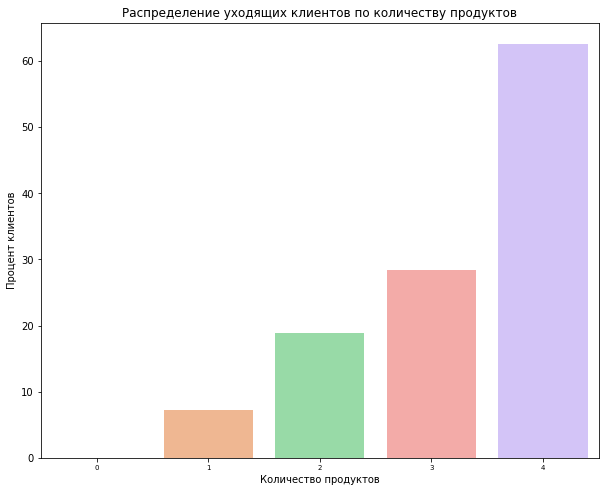

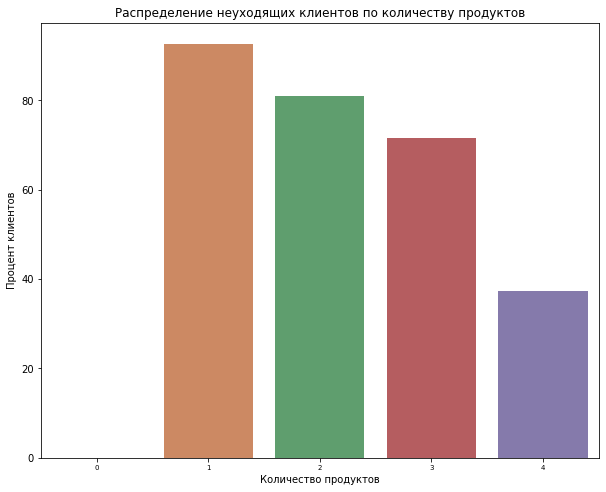

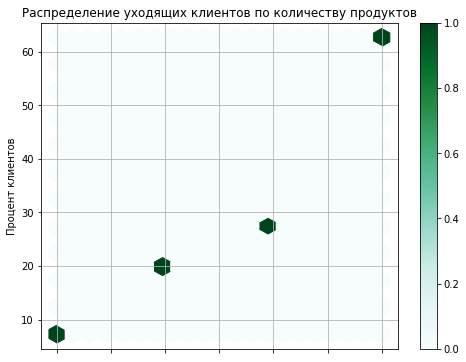

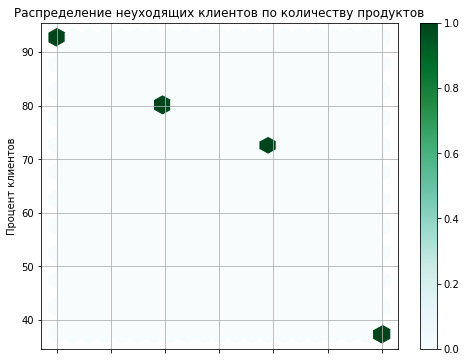

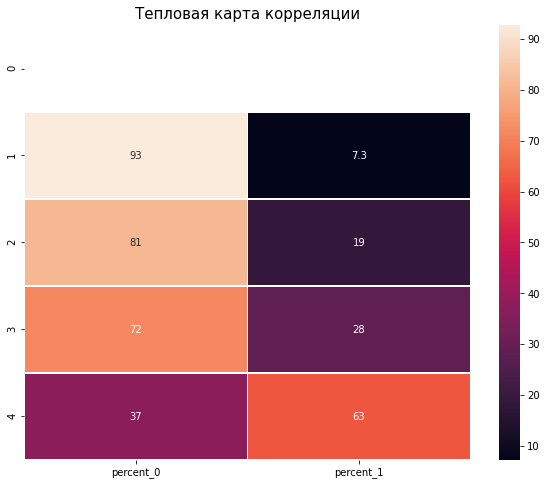

In [45]:
#создадим сводную таблицу с объектами собственности у клиента
churn_products = data.pivot_table(index='products', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_products.columns = ['products', 'churn_0', 'churn_1']
churn_products = churn_products.sort_values(by='products')
churn_products = churn_products.query('products <= 4')
churn_products['total'] = churn_products['churn_1'] + churn_products['churn_0']
churn_products['percent_total'] = (churn_products['total'] / churn_products['total'].sum() *100).round(2)
churn_products['percent_0'] = (churn_products['churn_0'] / churn_products['total'] *100).round(2)
churn_products['percent_1'] = (churn_products['churn_1'] / churn_products['total'] *100).round(2)

display(churn_products)

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='products', y='percent_1', data=churn_products, palette="pastel", ci=10)
plt.title('Распределение уходящих клиентов по количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='products', y='percent_0', data=churn_products, palette="deep")
plt.title('Распределение неуходящих клиентов по количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим гексагональную диаграмму для churn 1
churn_products.plot(x='products', y='percent_1', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)
plt.title('Распределение уходящих клиентов по количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Процент клиентов')
plt.show()

# строим гексагональную диаграмму для churn 0
churn_products.plot(x='products', y='percent_0', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)
plt.title('Распределение неуходящих клиентов по количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Процент клиентов')
plt.show()


custom_palette = sns.color_palette("rocket", as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(churn_products.iloc[:, 5:7], annot=True, linewidth=0.5, cmap=custom_palette)
ax.set_title('Тепловая карта корреляции', fontsize=15)
plt.show()


#### Промежуточный вывод

- Явно прослеживается взаимосвязь между количеством продуктов и оттоком клиентов: У клиентов с большим количеством продуктов банка отток больше;
- Обратная зависимость наблюдается у неуходящих клиентов; 

____

### Исследование взаимосвязи количество объектов собственности у клиента и оттока 

,equity,churn_0,churn_1,total,percbent_total,percent_0,percent_1
0,0,2207,85,2292,24.81,96.29,3.71
1,1,666,93,759,8.22,87.75,12.25
2,2,876,164,1040,11.26,84.23,15.77
3,3,1202,310,1512,16.37,79.50,20.50
4,4,1354,445,1799,19.47,75.26,24.74
5,5,1297,540,1837,19.88,70.60,29.40


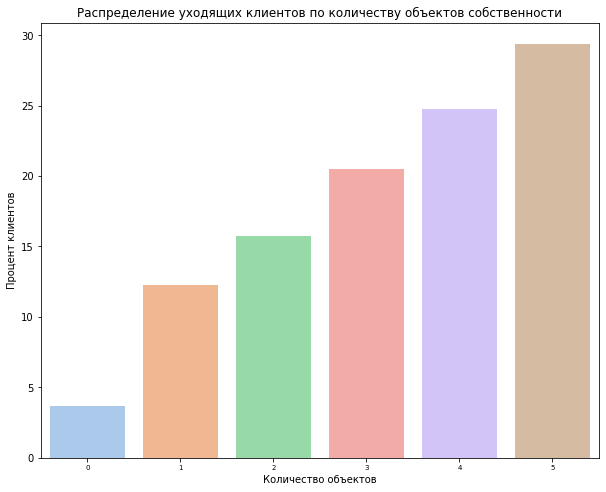

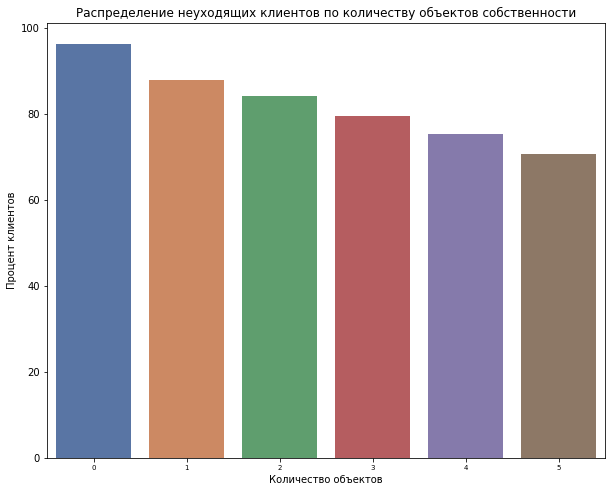

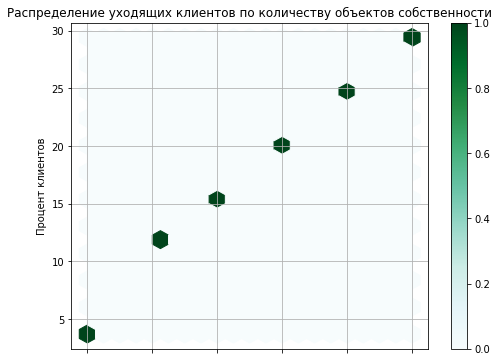

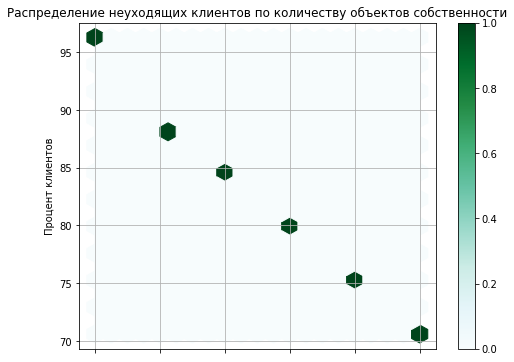

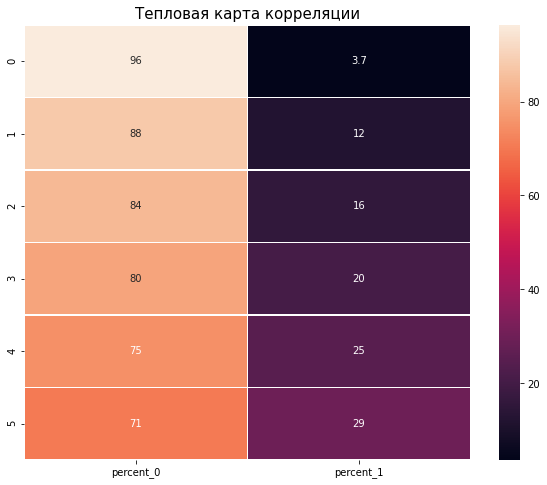

In [46]:
#создадим сводную таблицу с объектами собственности у клиента
churn_equity = data.pivot_table(index='equity', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_equity.columns = ['equity', 'churn_0', 'churn_1']
churn_equity = churn_equity.sort_values(by='equity')
churn_equity = churn_equity.query('equity <= 5')
churn_equity['total'] = churn_equity['churn_1'] + churn_equity['churn_0']
churn_equity['percbent_total'] = (churn_equity['total'] / churn_equity['total'].sum() *100).round(2)
churn_equity['percent_0'] = (churn_equity['churn_0'] / churn_equity['total'] *100).round(2)
churn_equity['percent_1'] = (churn_equity['churn_1'] / churn_equity['total'] *100).round(2)

display(churn_equity)

# строим график для churn 1
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='equity', y='percent_1', data=churn_equity, palette="pastel", ci=10)
plt.title('Распределение уходящих клиентов по количеству объектов собственности')
plt.xlabel('Количество объектов')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим график для churn 0
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='equity', y='percent_0', data=churn_equity, palette="deep")
plt.title('Распределение неуходящих клиентов по количеству объектов собственности')
plt.xlabel('Количество объектов')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=0, fontsize=7)
plt.show()

# строим гексагональную диаграмму для churn 1
churn_equity.plot(x='equity', y='percent_1', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)  
plt.title('Распределение уходящих клиентов по количеству объектов собственности')
plt.xlabel('Количество объектов')
plt.ylabel('Процент клиентов')
plt.show()

# строим гексагональную диаграмму для churn 0
churn_equity.plot(x='equity', y='percent_0', kind='hexbin', gridsize=20, figsize=(8, 6), grid=True)
plt.title('Распределение неуходящих клиентов по количеству объектов собственности')
plt.xlabel('Количество объектов')
plt.ylabel('Процент клиентов')
plt.show()


custom_palette = sns.color_palette("rocket", as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(churn_equity.iloc[:, 5:7], annot=True, linewidth=0.5, cmap=custom_palette)
ax.set_title('Тепловая карта корреляции', fontsize=15)
plt.show()


#### Промежуточный вывод

- Явно прослеживается взаимосвязь между количеством продуктов и оттоком клиентов: У клиентов с большим количеством объектов собственности  отток больше;
- Обратная зависимость наблюдается у неуходящих клиентов; 

____


### Исследование взаимосвязи зарплаты и оттока клиентов



,est_salary,churn_0,churn_1
0,10880.27,NaN,1.0
1,150922.60,NaN,1.0
2,151720.41,NaN,1.0
3,151660.38,NaN,1.0
4,151392.34,NaN,1.0
...,...,...,...
9492,316037.22,1.0,NaN
9493,316292.24,1.0,NaN
9494,316316.10,1.0,NaN
9495,316443.19,1.0,NaN


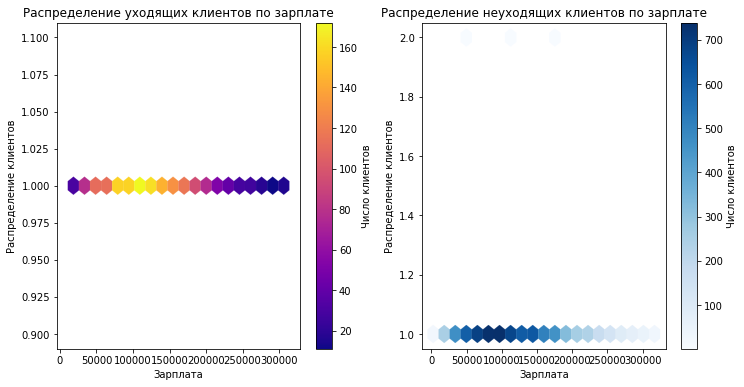

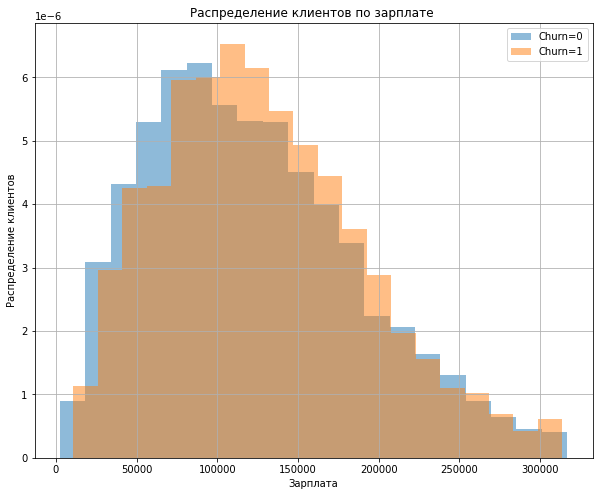

In [47]:
# создаем сводную таблицу с подсчетом churn 0 и churn 1 по зарплате клиентов 
churn_salary = data.pivot_table(index='est_salary', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_salary.columns = ['est_salary', 'churn_0', 'churn_1']
churn_salary = churn_salary.sort_values(by='churn_1', ascending=False)
churn_salary = churn_salary.reset_index(drop=True)

display(churn_salary)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# создаем гексагональную диаграмму для churn 1
churn_1 = ax[0].hexbin(x='est_salary', y='churn_1', data=churn_salary, gridsize=20, cmap='plasma', mincnt=1, linewidths=0.2)
ax[0].set(title='Распределение уходящих клиентов по зарплате', xlabel='Зарплата', ylabel='Распределение клиентов')

# создаем гексагональную диаграмму для churn 0
churn_0 = ax[1].hexbin(x='est_salary', y='churn_0', data=churn_salary, gridsize=20, cmap='Blues', mincnt=1, linewidths=0.2)
ax[1].set(title='Распределение неуходящих клиентов по зарплате', xlabel='Зарплата', ylabel='Распределение клиентов')

# добавляем цветовую шкалу к каждому графику
cb1 = fig.colorbar(churn_1, ax=ax[0])
cb1.set_label('Число клиентов')
cb2 = fig.colorbar(churn_0, ax=ax[1])
cb2.set_label('Число клиентов')


# построение гистограммы зарплаты с параметром density=True
plt.figure(figsize=(10, 8))
plt.hist(data.est_salary[data.churn == 0], bins=20, alpha=0.5, label='Churn=0', density=True)
plt.hist(data.est_salary[data.churn == 1], bins=20, alpha=0.5, label='Churn=1', density=True)
plt.title('Распределение клиентов по зарплате ')
plt.xlabel('Зарплата')
plt.ylabel('Распределение клиентов')
plt.grid(True)
plt.legend()
plt.show()



#### Промежуточный вывод

- Матрица распределения показывает распределение оттока в соотвествии с распределением данных по столбцу est_salary, за основу для дальнейшего анализа данных можно взять распределение зарплаты от 50.000 до 200.000 рублей;
- Количество неуходящих клиентов также распределено в соответствии с распределением значений в столбце est_salary;
- Взаимосвязи оттока клиентов и заработной платы не обнаружено.

____

### Исследование взаимосвязи баланса и оттока клиентов 

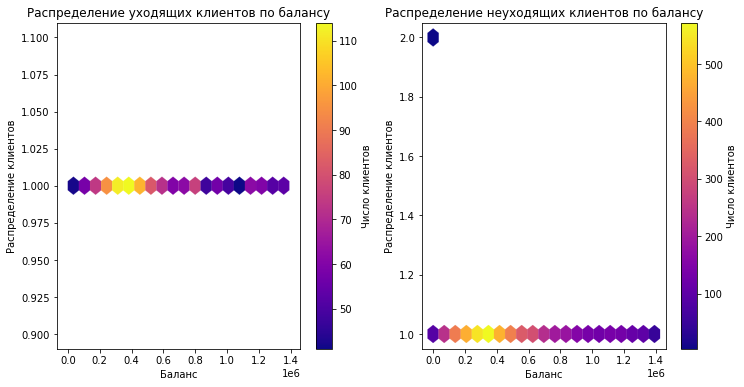

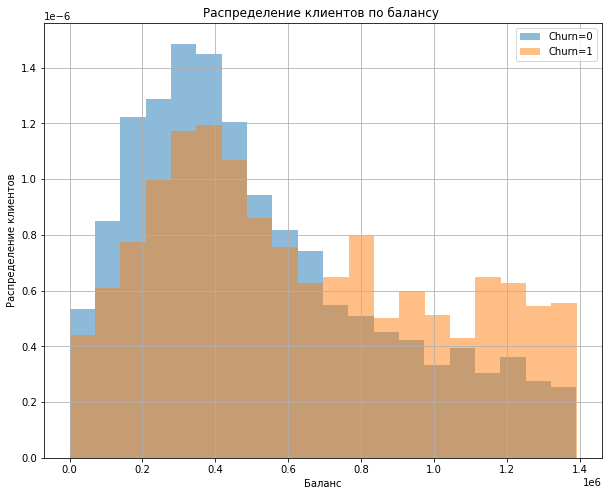

In [48]:
# создаем сводную таблицу с подсчетом churn 0 и churn 1 для каждого обладателя карты
churn_balance = data.pivot_table(index='balance', columns='churn', values='user_id', aggfunc='count').reset_index()
churn_balance.columns = ['balance', 'churn_0', 'churn_1']
churn_balance = churn_balance.sort_values(by='churn_1', ascending=False)
churn_balance = churn_balance.reset_index(drop=True)

balance_quantile = data['balance'].quantile(0.90)
churn_balance = churn_balance.query('balance < @balance_quantile')


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# создаем гексагональную диаграмму для churn 1
churn_1 = ax[0].hexbin(x='balance', y='churn_1', data=churn_balance, gridsize=20, cmap='plasma', mincnt=1, linewidths=0.2)
ax[0].set(title='Распределение уходящих клиентов по балансу', xlabel='Баланс', ylabel='Распределение клиентов')

# создаем гексагональную диаграмму для churn 0
churn_0 = ax[1].hexbin(x='balance', y='churn_0', data=churn_balance, gridsize=20, cmap='plasma', mincnt=1, linewidths=0.2)
ax[1].set(title='Распределение неуходящих клиентов по балансу', xlabel='Баланс', ylabel='Распределение клиентов')

# добавляем цветовую шкалу к каждому графику
cb1 = fig.colorbar(churn_1, ax=ax[0])
cb1.set_label('Число клиентов')
cb2 = fig.colorbar(churn_0, ax=ax[1])
cb2.set_label('Число клиентов')


# построение гистограммы баланса с параметром density=True
plt.figure(figsize=(10,8))
plt.hist(data.query('balance < @balance_quantile & churn == 0')['balance'], bins=20, alpha=0.5, label='Churn=0', density=True)
plt.hist(data.query('balance < @balance_quantile & churn == 1')['balance'], bins=20, alpha=0.5, label='Churn=1', density=True)
plt.title('Распределение клиентов по балансу ')
plt.xlabel('Баланс')
plt.ylabel('Распределение клиентов')
plt.grid(True)
plt.legend()
plt.show()


#### Промежуточный вывод

- Отток клиентов в взаимосвязи с балансом клиентов распределен равномерно по всему объему значений столбца balance, для устранения выбросов были взяты значения до 90 процентиля столбца, больше всего значений приходится на сумму около 250.000, есть некоторые пиковые значения оттока клиентов с большим балансом в районе 800.000, а также от 1.100.000 до 1.400.000 
- Большая часть неуходящих клиентов распределена по сумме баланса от 200.000 до 450.000, а затем плавно снижается с заметным отклонением в правую сторону, что свидетельствует о выбросах; 

____

### Дополнительное исследование взаимосвязи столбцов score и balance

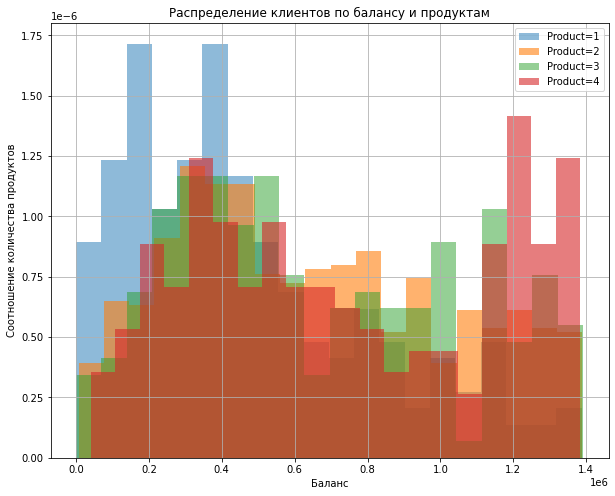

In [49]:
equity_quantile = data['equity'].quantile(0.95)
products_quantile = data['products'].quantile(0.95)

# построение гистограммы баланса с параметром density=True
plt.figure(figsize=(10, 8))
plt.hist(data.query('balance < @balance_quantile & products == 1 & churn == 1')['balance'], bins=20, alpha=0.5, label='Product=1', density=True)
plt.hist(data.query('balance < @balance_quantile & products == 2 & churn == 1')['balance'], bins=20, alpha=0.6, label='Product=2', density=True)
plt.hist(data.query('balance < @balance_quantile & products == 3 & churn == 1')['balance'], bins=20, alpha=0.5, label='Product=3', density=True)
plt.hist(data.query('balance < @balance_quantile & products == 4 & churn == 1')['balance'], bins=20, alpha=0.6, label='Product=4', density=True)
plt.title('Распределение клиентов по балансу и продуктам')
plt.xlabel('Баланс')
plt.ylabel('Соотношение количества продуктов')
plt.grid(True)
plt.legend()
plt.show()


#### Промежуточный вывод

- Наблюдается большое количество клиентов с одним продуктом у клиентов с балансом до 500.000 
- Также наблюдается большое количество клиентов с четырьмя продуктами у клиентов с балансом от 1.100.000

### Дополнительное исследование по оттоку клиентов по высоким рейтингам и большим балансам 

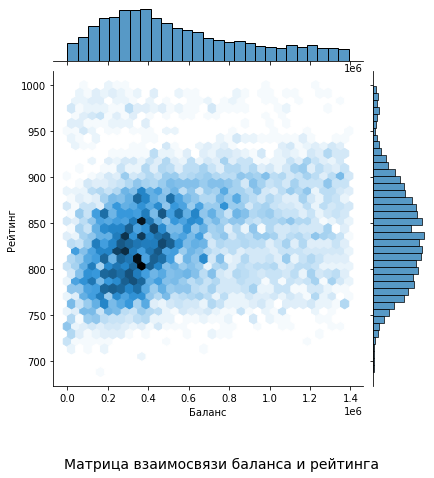

In [50]:
#дополнительно построим датафрейм для проверки связи между столбцами
data_score_balance = data[['score', 'balance']].dropna().reset_index(drop=True)
data_score_balance = data.query('balance < @balance_quantile')


#построим график 
sns.jointplot(x='balance', y='score', data=data_score_balance, kind='hex')
plt.xlabel('Баланс')
plt.ylabel('Рейтинг')
plt.figtext(0.5, -0.1, 'Матрица взаимосвязи баланса и рейтинга', ha='center', va='bottom', fontsize=14)
plt.show()



#### Промежуточный вывод

- Большое количество значений рейтинга от 800 до 900 распределено у клиентов с балансом от 200.000 до 500.000 рублей, взаимосвязи больших балансов и высоких рейтингов не обнаружено 
___

### Вывод Шаг 3.

Был проведен исследовательский анализ данных в котором последовательно изучалась взаимосвясь столбцов датасета bank_scrooge.csv со столбцом churn для определения причин оттока клиентов банка.

В результате были сформированы следующие выводы:

##### Добавление новых категорий и проверка распределения
- В столбцах products, equity, score данные имеют нормальное распределение; 
- В столбце age, est_salary график отноняется вправо по оси Х, что означает - данные имеют асимметричное распределение. Скошенность вправо указывает на наличие выбросов или аномалий среди более высоких значений, которые могут повлиять на анализ и интерпретацию данных, рекомендуется учитывать это при дальнейшем анализе данных;
- Столбец balance имеет большую аномальную часть значений, но мы будем учитывать их в дальнейшем анализе. 
- Больше всего значений в категории рейтинга "Хороший" (809 – 890 баллов), примерно равное количество в категории "Очень хороший" (891 – 999 баллов) и "Средний" (711 – 808 баллов), практически отсутсвует категория "Низкий" рейтинг (1 – 710 баллов), что делает затруднительным дальнейший анализ по категориям рейтинга и проверка гипотезы "Клиенты с более низким рейтингом в большей степени являются уходящими клиентами банка"
- Больше всего значений возрастной категории "Среднего возраста" (4615 пользователей) , затем "Клиенты молодого возраста" (3136 пользователей) и "Клиенты старшего возраста" (1749 пользователей); 
- Данные по городам распределены неравномерно, больше всего значений в городе "Ярославль", меньше всего в городе "Ростов", что также может влиять на результы исследования, но не в большой степени


##### Построение тепловой карты корреляции для определения взаимосвязей данных
- Были изменены данные столбца gender и присвоены значения: 1 - Мужчины, 0 - Женщины для корректного постороения таблицы корреляции;
- Функцией get_dummies было выделено 3 отдельных столбца городов для анализа корреляции;
- Тепловая карта корреляции для определения взаимосвязи между данными столбцов датасета и столбца churn показала следующие результаты:
        - Средняя Взаимосвязь наблюдается столбца churn наблюдается с столбцами "equity", "products", "last_activity";
        - Менее значительные показатели взаимосвязи, наблюдаются с столбцами "gender", "credit_card"
        - В остальных столбцах тепловая карта корреляции не показала взаимосвязи со столбцом churn.
- Отдельно от столбца churn наблюдается взаимосвязь между столбцами "equity" и "products", а также обратная взаимосвязь между городами: "при увеличении клиентов в одном городе уменьшается количество клиентов в другом", что логично. 


##### Исследование взаимосвязи городов и оттока клиентов (city)
- Больший отток клиентов наблюдается в городе "Ярославль", это может быть связано с большим количеством клиентов в данном городе, а меньше всего отток в городе "Рыбинск", в дальнейшем исследовании можно учесть этот показатель для ; 
- Неуходящие клиенты банка распределены равномерно между городами.


##### Исследование взаимосвязи возраста и оттока клиентов (age)
- Отличительно больший отток происходит у клиентов молодого возраста;
- Неуходящие клиенты распределены нормально по всем категориям; 
- При более подробном исследовании сегмента было обнаружено 2 пика по количеству уходящих клиентов:
        - Клиенты молодого и среднего возраста от 28 до 44 лет;
        - Клиенты старшего возраста от 49 до 60 лет; 
- Матрица распределения также указывает на большое количество значений в данных областях;
- Больше всего неуходящих клиентов приходится на средний возраст клиентов от 35 лет.


##### Исследование взаимосвязи рейтингов и оттока клиентов (score)
- Отличительно больший отток происходит у клиентов категории рейтинга "Хороший" и "Очень хороший";
- Неуходящих клиентов больше всего в категории рейтинга "Низкий", но т.к. эта категория очень незначительная ее нельзя брать во внимание, а меньше всего в категориях рейтинга "Хороший" и "Очень хороший"; 
- При более подробном исследовании сегмента было обнаружен пик по количеству уходящих клиентов:
        - Клиенты категории рейтинга "Хороший" и рейтингом от 850 до 900;
- Матрица распределения также указывает на большое количество значений в данных областях, а также распределение уходящих клиентов в категории "Низкий", и "Очень хороший";


##### Исследование взаимосвязи гендерного признака и оттока клиентов (gender)
- Практически в 2 раза больше отток клиентов мужчин; 
- Больше всего неуходящих клиентов - женщин. 


##### Исследование взаимосвязи наличия карты и оттока клиентов (credit_card)
- Отток происходит в большей степени у клиентов без кредитной карты;
- Неуходящих клиентов с кредитной карты больше, чем без неё.


##### Исследование взаимосвязи активности клиента и оттока (last_activity)
- В большей степени отток клиентов происходит у активных клиентов, вероятно это связано с фиксированием каких либо действий перед уходом;
- Неуходящие клиенты по активности распределены нормально;


##### Исследование взаимосвязи количества продуктов и оттока клиентов (products)
- Явно прослеживается взаимосвязь между количеством продуктов и оттоком клиентов: У клиентов с большим количеством продуктов банка отток больше;
- Обратная зависимость наблюдается у неуходящих клиентов; 


##### Исследование взаимосвязи объектов собственности и оттока клиентов (equity)
- Явно прослеживается взаимосвязь между количеством продуктов и оттоком клиентов: У клиентов с большим количеством объектов собственности  отток больше;
- Обратная зависимость наблюдается у неуходящих клиентов; 


##### Исследование взаимосвязи зарплаты и оттока клиентов (est_salary)
- Матрица распределения показывает распределение оттока в соотвествии с распределением данных по столбцу est_salary, за основу для дальнейшего анализа данных можно взять распределение зарплаты от 50.000 до 200.000 рублей;
- Количество неуходящих клиентов также распределено в соответствии с распределением значений в столбце est_salary;
- Взаимосвязи оттока клиентов и заработной платы не обнаружено.


##### Исследование взаимосвязи баланса  и оттока клиентов (balance)
- Отток клиентов в взаимосвязи с балансом клиентов распределен равномерно по всему объему значений столбца balance, для устранения выбросов были взяты значения до 90 процентиля столбца, больше всего значений приходится на сумму около 250.000, есть некоторые пиковые значения оттока клиентов с большим балансом в районе 800.000, а также от 1.100.000 до 1.400.000 
- Большая часть неуходящих клиентов распределена по сумме баланса от 200.000 до 450.000, а затем плавно снижается с заметным отклонением в правую сторону, что свидетельствует о выбросах; 


### Рекомендации для дальнейшего исследования, сегментации данных и проверки статистических гипотез:

- Сегментировать клиентов по столбцу 'equity': 
        - Проверить клиентов с большим количеством объектов собственности;
- Сегментировать клиентов по столбцу 'products':
        - Выделить категории клиентов:
                A - С одним продуктом;
                B - С двумя продуктами;
                C - С тремя продуктами;
- Сегментировать клиентов по столбцу 'balance' и проверить отток клиентов с большими балансами;
- Сегментировать клиентов по столбцу 'score', так как было обнаружен отток клиентов с высокими рейтингами;
        - Проверить соотношение в столбцах и проверить корреляцию клиентов с большими балансами и высокими рейтингами; 
- Сегментировать клиентов по столбцу 'age', и проверить гипотезу "Различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним."
- Дополнительно проверить взаимосвязь "churn" и данных в столбцах "gender", и проверить гипотезу "Отток клиентов женщин ниже, чем клиентов мужчин"

___

____

## Шаг 4. Сегментация

- Построить тепловую карту корреляции по оттоку клиентов для определения дополнительных путей исследования;
- Сегментировать клиентов по столбцу 'products':
        - Выделить категории клиентов:
                A - С одним продуктом;
                B - С двумя продуктами;
                C - С тремя продуктами;
                D - С четырьмя продуктами; 
- Сегментировать клиентов по столбцу 'score' и 'equity', так как было обнаружен отток клиентов с высокими рейтингами и обнаружена взаимосвязь между score и equity; 
- Сегментировать клиентов по столбцу 'churn', 'age', 'products', для проверки гипотез 
        - "Различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним." 
        - "У клиентов с большим количеством продуктов банка отток ниже, чем у клиентов с меньшим количеством продуктов"
- Сегментировать клиентов по столбцам 'churn', 'score' для проверки гипотезы: "В банках с рейтингом ниже, отток клиентов больше, чем в банках с высоким рейтингом" 
- Дополнительно проверить взаимосвязь "churn" и данных в столбцах "gender", для проверки гипотезы "Отток клиентов женщин ниже, чем клиентов мужчин"
- Проверить распределение между группами с помощью критерия Манна-Уитни.

###  Создание датафрейма для сегментации

In [51]:
#для сегментации выделим необходимые столбцы в отдельный датафрейм
data_section = data[['user_id', 'city', 'churn', 'equity', 'products', 'balance', 'score', 'age', 'gender']].reset_index(drop=True)
data_section.head()

,user_id,city,churn,equity,products,balance,score,age,gender
0,183012,Рыбинск,1,1,2,59214.82,850.0,25,0
1,146556,Рыбинск,0,5,3,850594.33,861.0,37,0
2,120722,Рыбинск,0,0,1,NaN,892.0,30,0
3,225363,Ярославль,1,5,2,1524746.26,866.0,51,0
4,157978,Ярославль,1,5,1,174.00,730.0,34,1


#### Промежуточный вывод

- Был создан датафрейм data_section для сегментации

### Создание тепловой карты корреляции уходящих клиентов

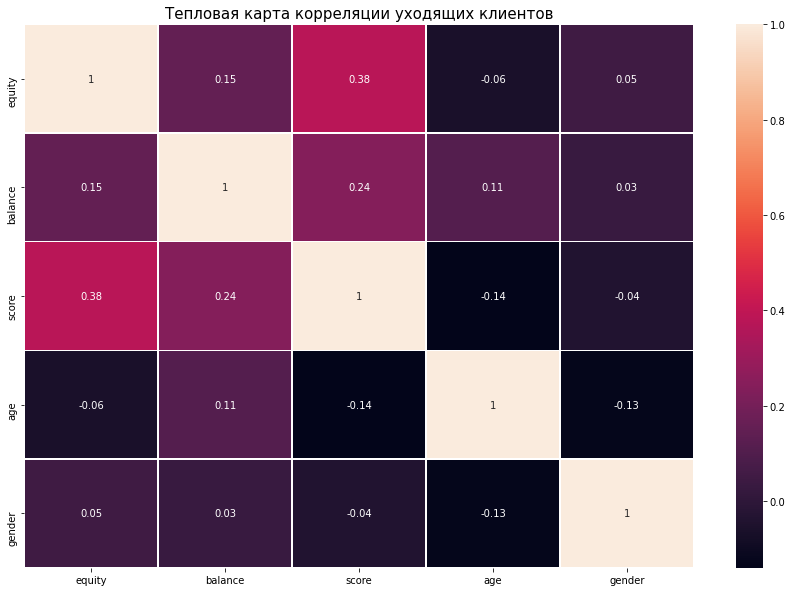

In [52]:
#создадим тепловую карту для исследования корреляции уходящих клиентов
data_corr = data_section.query('churn == 1').drop(['user_id', 'churn', 'products'], axis=1).corr().round(2)
custom_palette = sns.color_palette("rocket", as_cmap=True)
plt.figure(figsize=(15, 10))
ax = sns.heatmap(data_corr, annot=True, linewidth=0.5, cmap=custom_palette)
ax.set_title('Тепловая карта корреляции уходящих клиентов', fontsize=15)
plt.show()

In [53]:
#создадим дубликат столбца products потому что по какой то причине drop_first=False не работает и удаляет столбец products 
data_section = data_section.assign(products_d = data_section['products'])
#методом get_dummies выделим 4 отдельных столбца городов для проверки распределения между столбцами 
data_section = pd.get_dummies(data_section, columns=['products_d'])
data_section = data_section.drop(['products_d_0', 'products_d_5'], axis=1)
data_section


,user_id,city,churn,equity,products,balance,score,age,gender,products_d_1,products_d_2,products_d_3,products_d_4
0,183012,Рыбинск,1,1,2,59214.82,850.0,25,0,0,1,0,0
1,146556,Рыбинск,0,5,3,850594.33,861.0,37,0,0,0,1,0
2,120722,Рыбинск,0,0,1,NaN,892.0,30,0,1,0,0,0
3,225363,Ярославль,1,5,2,1524746.26,866.0,51,0,0,1,0,0
4,157978,Ярославль,1,5,1,174.00,730.0,34,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,120553,Рыбинск,0,1,1,78144.65,814.0,27,1,1,0,0,0
9496,139170,Ярославль,0,0,1,NaN,894.0,46,1,1,0,0,0
9497,115639,Ярославль,0,0,2,NaN,903.0,24,1,0,1,0,0
9498,148700,Ярославль,0,3,3,865457.97,777.0,68,0,0,0,1,0


#### Промежуточный вывод

- Был сформирован отдельный датафрейм для проверки статистической значимости между столбцами 
- Также была построена тепловая карта по уходящим клиентам для определения дополнительной взаимосвязи между столбцами и была обнаружена взаимосвязь между столбцами 'score' и 'equity'
___

### Сегментирование клиентов по столбцам 'score' и 'equity', дополнительное исследование взаимосвязи 

In [54]:
df_score_equity = data_section[['score', 'equity', 'churn']]
df_score_equity

,score,equity,churn
0,850.0,1,1
1,861.0,5,0
2,892.0,0,0
3,866.0,5,1
4,730.0,5,1
...,...,...,...
9495,814.0,1,0
9496,894.0,0,0
9497,903.0,0,0
9498,777.0,3,0


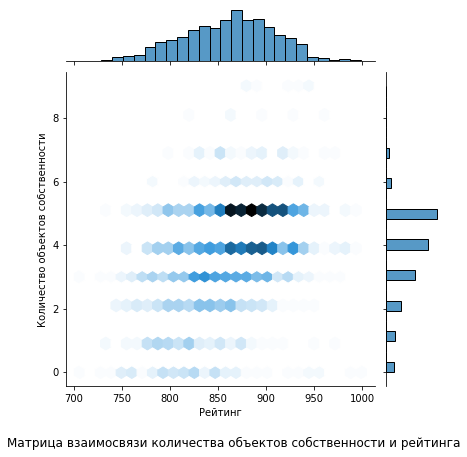

In [55]:
#построим график 
sns.jointplot(x='score', y='equity', data=df_score_equity.query('churn == 1'), kind='hex')
plt.xlabel('Рейтинг')
plt.ylabel('Количество объектов собственности')
plt.figtext(0.5, -0.05, 'Матрица взаимосвязи количества объектов собственности и рейтинга', ha='center', va='bottom', fontsize=12)
plt.show()

#### Промежуточный вывод

- Была обнаружена взаимосвязь между большим количеством объектов собственности и кредитным рейтингом, что  логично, т.к. банк формирует свой рейтинг во многом исходя из количества объектов собственности у клиента.

___

### Сегментирование клиентов по столбцам 'churn', 'age', 'products'

In [56]:
df_age_products = data_section[['churn', 'age', 'products_d_1', 'products_d_2', 'products_d_4']]
df_age_products_sorted_d1 = df_age_products.sort_values('products_d_1', ascending=False)
df_age_products_sorted_d2 =  df_age_products.sort_values('products_d_2', ascending=False)

display(df_age_products)



,churn,age,products_d_1,products_d_2,products_d_4
0,1,25,0,1,0
1,0,37,0,0,0
2,0,30,1,0,0
3,1,51,0,1,0
4,1,34,1,0,0
...,...,...,...,...,...
9495,0,27,1,0,0
9496,0,46,1,0,0
9497,0,24,0,1,0
9498,0,68,0,0,0


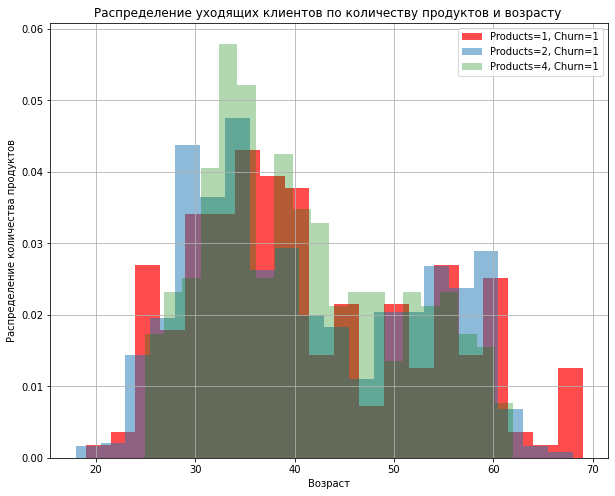

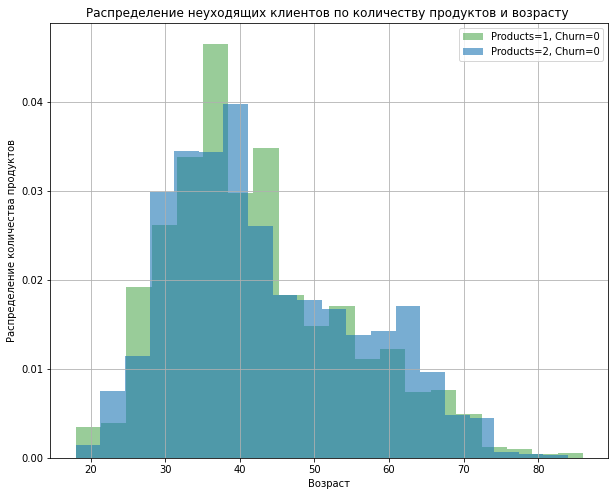

In [57]:
#построить тут histplot

# построение гистограммы баланса клиентов, которые используют один продукт и два продукта
plt.figure(figsize=(10, 8))
plt.hist(df_age_products.query('churn == 1')['age'].loc[df_age_products['products_d_1']==1], bins=20, alpha=0.7, label='Products=1, Churn=1', density=True, color='red')
plt.hist(df_age_products.query('churn == 1')['age'].loc[df_age_products['products_d_2']==1], bins=20, alpha=0.5, label='Products=2, Churn=1', density=True)
plt.hist(df_age_products.query('churn == 1')['age'].loc[df_age_products['products_d_4']==1], bins=20, alpha=0.3, label='Products=4, Churn=1', density=True, color='green')
plt.title('Распределение уходящих клиентов по количеству продуктов и возрасту ')
plt.xlabel('Возраст')
plt.ylabel('Распределение количества продуктов')
plt.grid(True)
plt.legend()
plt.show()

# построение гистограммы баланса клиентов, которые используют один продукт и два продукта
plt.figure(figsize=(10, 8))
plt.hist(df_age_products.query('churn == 0')['age'].loc[df_age_products['products_d_1']==1], bins=20, alpha=0.4, label='Products=1, Churn=0', density=True, color='green')
plt.hist(df_age_products.query('churn == 0')['age'].loc[df_age_products['products_d_2']==1], bins=20, alpha=0.6, label='Products=2, Churn=0', density=True)
plt.title('Распределение неуходящих клиентов по количеству продуктов и возрасту ')
plt.xlabel('Возраст')
plt.ylabel('Распределение количества продуктов')
plt.grid(True)
plt.legend()
plt.show()


#### Промежуточный вывод

- Был сформирован датафрейм с данными 'churn', 'age', 'products'
- В результате исследования не обнаружена взаимосвязь оттока клиентов с двумя продуктами банка и с одним продуктом, но прослеживается взаимосвязь оттока клиентов с 4мя продуктами возрастной группы от 30 до 40 лет
____

### Сегментирование клиентов по столбцам 'churn', 'products', 'products_d_n'

In [58]:
df_churn_products = data_section[['churn', 'products_d_1', 'products_d_3', 'products_d_4']]
df_churn_products.head()

#df_churn_products.groupby('churn').agg({'products_d_1':'sum', 'products_d_3': 'sum', 'products_d_4': 'sum'})

,churn,products_d_1,products_d_3,products_d_4
0,1,0,0,0
1,0,0,1,0
2,0,1,0,0
3,1,0,0,0
4,1,1,0,0


#### Промежуточный вывод

- Был сформирован датафрейм из данных 'churn', 'products', 'products_d_n'

____

### Сегментирование клиентов по столбцам 'churn', 'score'

In [59]:
df_churn_score = data_section[['churn', 'score']]
df_churn_score

,churn,score
0,1,850.0
1,0,861.0
2,0,892.0
3,1,866.0
4,1,730.0
...,...,...
9495,0,814.0
9496,0,894.0
9497,0,903.0
9498,0,777.0


#### Промежуточный вывод

- Был сформирован датафрейм 'churn', 'score'
____

### Сегментирование клиентов по столбцам 'churn' и данных в столбцах 'gender'

In [60]:
df_churn_gender = data_section[['churn', 'gender']]
df_churn_gender


,churn,gender
0,1,0
1,0,0
2,0,0
3,1,0
4,1,1
...,...,...
9495,0,1
9496,0,1
9497,0,1
9498,0,0


#### Промежуточный вывод 

- Был сформирован датафрейм с данными 'churn' 'gender'


____

### Вывод Шаг 4. 

Сегмент: Отдельные виды данных для проверки статистической значимости между столбцами   
Описание:   
Для проверки статистической значимости между данными был сформирован отдельный датафрейм data_section, который включает в себя	city - данные о городах,	churn - ушел или не ушел клиент,	equity - количество объектов собственности,	products - количество продуктов банка у клиента,	balance	- баланс, score - рейтинг кредитного скорринга,	age - возраст клиента,	gender	- пол

- Была построена тепловая карта для уходящих клиентов для определения дополнительной взаимосвязи между столбцами. В результате была обнаружена взаимосвязь между столбцами 'score' и 'equity'. 

Сегмент: Взаимосвязь между количеством объектов собственности и кредитным рейтингом   
Описание:   
Состав сегмента: equity - количество объектов собственности, score - рейтинг кредитного скорринга.
Обнаружена взаимосвязь между большим количеством объектов собственности и кредитным рейтингом.

Сегмент: Возраст клиентов в зависимости от количества продуктов  
Описание:   
Был сформирован датафрейм с данными churn - ушел или не ушел клиент, 'age' - возраст клиента, products - количество продуктов банка у клиента, для дальнейшего анализа.  
Обнаружена взаимосвязь между оттоком клиентов с двумя продуктами банка и с одним продуктом, но прослеживается взаимосвязь оттока клиентов с 4мя продуктами возрастной группы от 30 до 40 лет.

Сегмент: Взаимосвязь между оттоком клиентов и количеством продуктов   
Описание:  
Был сформирован датафрейм из данных churn - ушел или не ушел клиент, products - количество продуктов банка у клиента, 'products_d_n' - полученный через get_dummies, разделенный датафрейм на количество продуктов,  для дальнейшего анализа.

Сегмент: Взаимосвязь между рейтингом и оттоком клиентов   
Описание:  
Был сформирован датафрейм с данными churn - ушел или не ушел клиент, score - рейтинг кредитного скорринга, для дальнейшего анализа.

Сегмент: Взаимосвязь между гендерным признаком и оттоком клиентов   
Описание:  
Был сформирован датафрейм с данными 'churn' - отток, 'gender' - пол, для дальнейшего анализа.
____

## Шаг 5. Статистическая проверка гипотез 


- Проверить распределение между группами с помощью критерия Манна-Уитни;


Основное задание:  
- Определить и проверить гипотезу:  
"Различие возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним."
- Определить и проверить гипотезу:  
"У клиентов с большим количеством продуктов банка отток ниже, чем у клиентов с меньшим количеством продуктов"

Дополнительное задание:
- Проверить гипотезу:  
"В банках с рейтингом ниже, отток клиентов больше, чем в банках с высоким рейтингом" 
 
- Проверить гипотезу:  
"Отток клиентов женщин ниже, чем клиентов мужчин" 


In [61]:
#проверяем распределение products через тест Манна Уитни

'''
Нулевая гипотеза (H0): Различия в распределении между столбцами статистически не значимы
Альтернативная гипотеза (H1): Различия в распределении между столбцами статистически значимы 
'''

#задаем alpha
alpha = 0.05
#добавляем поправку Бонферрони на множественную проверку гипотез
num_hypotheses = len(list(combinations(['products_d_1', 'products_d_2', 'products_d_3', 'products_d_4'], 2)))

for (col1, col2) in combinations(['products_d_1', 'products_d_2', 'products_d_3', 'products_d_4'], 2):
    stat, p_value = mannwhitneyu(data_section[col1], data_section[col2])
    if p_value < alpha/num_hypotheses: #применяем поправку на множественные сравнения
        print(f"Нулевая гипотеза отвергается, различия в распределении между '{col1}' и '{col2}' значимы")
    else:
        print(f"Нулевая гипотеза не отвергается, различия в распределении между '{col1}' и '{col2}' не значимы")


Нулевая гипотеза отвергается, различия в распределении между 'products_d_1' и 'products_d_2' значимы
Нулевая гипотеза отвергается, различия в распределении между 'products_d_1' и 'products_d_3' значимы
Нулевая гипотеза отвергается, различия в распределении между 'products_d_1' и 'products_d_4' значимы
Нулевая гипотеза отвергается, различия в распределении между 'products_d_2' и 'products_d_3' значимы
Нулевая гипотеза отвергается, различия в распределении между 'products_d_2' и 'products_d_4' значимы
Нулевая гипотеза отвергается, различия в распределении между 'products_d_3' и 'products_d_4' значимы


#### Промежуточный вывод

- Была применена статистическая тестирование на основе непараметрического критерия Манна-Уитни для попарных сравнений между столбцами 'products_d_1', 'products_d_2', 'products_d_3', 'products_d_4'. Была применена поправка Бонферрони на множественные сравнения. 
- В результате проведенной проверки между группами по количеству продуктов было выявлено, что различия между каждой группой в распределении являются значимыми, что означает, что возможно количество продуктов влияет на решение клиента об уходе из банка, для корреляции оттока и количества продуктов был проведен дополнительный анализ.
 

___

### Определение и проверка гипотезы о различии возраста между клиентами и количеством продуктов

In [62]:
#разделим выборки на две группы
group1 = df_age_products[(df_age_products['products_d_1'] == 1)]['age']
group2 = df_age_products[(df_age_products['products_d_1'] == 0) & (df_age_products['products_d_2'] == 1)]['age']


#определим гипотезы 
'''
- Нулевая гипотеза (H0): нет различий в возрасте между клиентами, которые используют один продукт банка, и теми, которые используют два продукта банка.
- Альтернативная гипотеза (H1): есть статистически значимые различия в возрасте между клиентами, которые используют один продукт банка, и теми, которые используют два продукта банка.
'''

#задаем параметр aplha
alpha = 0.05

#проведем тест Манна Уитни
stat, p_value = mannwhitneyu(group1, group2)

#вывод результата теста
print('U-statistic:', stat)
print('p-value:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между возрастом клиентов, которые используют один и два продукта банка, есть статистически значимые различия.')
else:
    print('Не удалось отвергнуть нулевую гипотезу: между возрастом клиентов, которые используют один и два продукта банка, нет статистически значимых различий.')


U-statistic: 7392160.5
p-value: 0.03580334353147327
Отвергаем нулевую гипотезу: между возрастом клиентов, которые используют один и два продукта банка, есть статистически значимые различия.


#### Промежуточный вывод

- Нулевая гипотеза отвергается, между возрастом клиентов, которые используют один и два продукта банка, есть статистически значимые различия, это означает, что количество продуктов, которыми пользуются клиенты, может обуславливаться возрастом клиента.

___

### Определение и проверка гипотезы о количестве продуктов банка и оттока

In [63]:
# разделим выборки на три группы
group_1 = df_churn_products[df_churn_products['products_d_1'] == 1]['churn']
group_3 = df_churn_products[df_churn_products['products_d_3'] == 1]['churn']
group_4 = df_churn_products[df_churn_products['products_d_4'] == 1]['churn']

# определим гипотезы
'''
1. Нулевая гипотеза (H0): Нет статистически значимой разницы между оттоком клиентов с 1 продуктом и оттоком клиентов с 3 продуктами.
2. Альтернативная гипотеза (H1): Есть статистически значимая разница между оттоком клиентов с 1 продуктом и оттоком клиентов с 3 продуктами.

3. Нулевая гипотеза (H0): Нет статистически значимой разницы между оттоком клиентов с 1 продуктом и оттоком клиентов с 4 продуктами.
4. Альтернативная гипотеза (H1): Есть статистически значимая разница между оттоком клиентов с 1 продуктом и оттоком клиентов с 4 продуктами.

'''

# задаем параметр alpha
alpha = 0.05

# сравнение групп с использованием z-критерия для долей
stat, p_value_1_3 = proportions_ztest([group_1.sum(), group_3.sum()], [len(group_1), len(group_3)])
print(f'Сравнение группы с 1 продуктом и группы с 3 продуктами: p-value = {p_value_1_3}')

stat, p_value_1_4 = proportions_ztest([group_1.sum(), group_4.sum()], [len(group_1), len(group_4)])
print(f'Сравнение группы с 1 продуктом и группы с 4 продуктами: p-value = {p_value_1_4}')

# Вывод результатов проверки гипотез
def hypothesis_result(p_value):
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть статистически значимая разница между оттоком клиентов и количеством продуктов.')
    else:
        print('Не удалось отвергнуть нулевую гипотезу: нет статистически значимой разницы между оттоком клиентов и количеством продуктов.')

print()
print("Гипотезы 1 и 2:")
hypothesis_result(p_value_1_3)
print()
print("Гипотезы 3 и 4:")
hypothesis_result(p_value_1_4)

Сравнение группы с 1 продуктом и группы с 3 продуктами: p-value = 1.1920497429329643e-68
Сравнение группы с 1 продуктом и группы с 4 продуктами: p-value = 3.8025151792998885e-213

Гипотезы 1 и 2:
Отвергаем нулевую гипотезу: есть статистически значимая разница между оттоком клиентов и количеством продуктов.

Гипотезы 3 и 4:
Отвергаем нулевую гипотезу: есть статистически значимая разница между оттоком клиентов и количеством продуктов.


#### Промежуточный вывод

- Нулевая гипотеза отвергается, есть статистически значимая разница между оттоком клиентов и количеством продуктов, это означает, что количество продуктов, которыми пользуются клиенты, может влиять на их вероятность уйти из банка.

___


### Определение и проверка гипотезы о различии  кредитного рейтинга и оттока

In [64]:
#определим порог для разделения банков на две группы ниже которого рейтинг будет считаться низким и следующий высоким
low_threshold = 710
high_threshold = 808

#разделим данные на две группы: низкий рейтинг и высокий рейтинг
low_rating = df_churn_score[df_churn_score['score'] < low_threshold]
high_rating = df_churn_score[df_churn_score['score'] >= high_threshold]

#определим гипотезы 
'''
- Нулевая гипотеза (H0): нет различий по кредитному рейтингу между клиентами.
- Альтернативная гипотеза (H1): есть статистически значимые различия по кредитному рейтингу между клиентами.
'''

#сравненим группы с использованием критерия Манна-Уитни
stat, p_value = mannwhitneyu(low_rating['churn'], high_rating['churn'])

#задаем параметр aplha 
alpha = 0.05

#выводим результаты
print('U-statistic:', stat)
print('p-value:', p_value)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая разница между группами")
else:
    print("Не удалось отвергнуть нулевую гипотезу: нет статистически значимой разницы между группами")


U-statistic: 595191.5
p-value: 1.4755345359126485e-13
Отвергаем нулевую гипотезу: есть статистически значимая разница между группами


#### Промежуточный вывод

- Нулевая гипотеза отвергается, есть статистически значимая разница между рейтингом клиентов и оттоком, это означает, что исследование рейтинга клиентов оправдано и может влиять на вероятность клиентов уйти из банка.

___

### Определение и проверка гипотезы о различии гендерного признака и оттока

In [65]:
#разделим выборки на две группы
group1 = df_churn_gender[(df_churn_gender['gender'] == 1)]['churn']
group2 = df_churn_gender[(df_churn_gender['gender'] == 0)]['churn']

#определяем гипотезы 
'''
- Нулевая гипотеза (H0):  нет статистически значимых различий между группами.
- Альтернативная гипотеза (H1): между группами есть статистически значимые различия.
'''

#вычисляем доли
p1 = group1.mean()
p2 = group2.mean()

#вычисляем разницу долей
diff = p1 - p2

#вычисляем стандартную ошибку
n1 = len(group1)
n2 = len(group2)
SE = np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)

#вычисляем z-статистику
z_stat = diff / SE

#вычисляем p-значение
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

#выводим результаты
print('z-statistic:', z_stat)
print('p-value:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть статистически значимые различия.')
else:
    print('Не удалось отвергнуть нулевую гипотезу: нет статистически значимых различий между группами.')


z-statistic: 13.940369247235939
p-value: 0.0
Отвергаем нулевую гипотезу: между группами есть статистически значимые различия.


#### Промежуточный вывод

- Нулевая гипотеза отвергается, есть статистически значимая разница между гендерным признаком клиентов и оттоком, это означает, что исследование гендерного признака клиентов оправдано и может влиять на вероятность клиента уйти из банка.
- В данном случае, полученное p-value равно 0, что говорит о наличии статистически значимых различий между клиентами по гендерному признаку.

___

### Вывод Шаг 5.

В результате статистической проверки значений: 

- Проверка между группами по количеству продуктов было выявлено:
         - Различия между каждой группой в распределении являются значимыми, что означает, что возможно количество продуктов влияет на решение клиента об уходе из банка, для корреляции оттока и количества продуктов был проведен дополнительный анализ.


- Проверка гипотезы о различии возраста между клиентами и количеством продуктов;
        - Нулевая гипотеза отвергается, между возрастом клиентов, которые используют один и два продукта банка, есть статистически значимые различия, это означает, что количество продуктов, которыми пользуются клиенты, может обуславливаться возрастом клиента.
        
        
- Определение и проверка гипотезы о количестве продуктов банка и оттока;
        - Нулевая гипотеза отвергается, есть статистически значимая разница между оттоком клиентов и количеством продуктов, это означает, что количество продуктов, которыми пользуются клиенты, может влиять на их вероятность уйти из банка.


- Определение и проверка гипотезы о различии кредитного рейтинга и оттока;
        - Нулевая гипотеза отвергается, есть статистически значимая разница между рейтингом клиентов и оттоком, это означает, что исследование рейтинга клиентов оправдано и может влиять на вероятность клиентов уйти из банка.


- Определение и проверка гипотезы о различии гендерного признака и оттока. 
        - Нулевая гипотеза отвергается, есть статистически значимая разница между гендерным признаком клиентов и оттоком, это означает, что исследование гендерного признака клиентов оправдано и может влиять на вероятность клиента уйти из банка.









____

# Общие выводы 


## Результаты исследования и основные инсайты данных

Сегмент: Количество продуктов   
 - в результате статистической проверки значений количество продуктов влияет на решение клиента об уходе из банка, для корреляции оттока и количества продуктов был проведен дополнительный анализ;
- в результате исследования не обнаружена взаимосвязь оттока клиентов с двумя продуктами банка и с одним продуктом, но прослеживается взаимосвязь оттока клиентов с 4мя продуктами возрастной группы от 30 до 40 лет;

Сегмент:  Возраст клиента 
- было обнаружено 2 пика по количеству уходящих клиентов:
                - Клиенты молодого и среднего возраста от 28 до 44 лет;
                - Клиенты старшего возраста от 49 до 60 лет; 
- между возрастом клиентов, есть статистически значимые различия, это означает, что количество продуктов, которыми пользуются клиенты, может обуславливаться возрастом клиента- 

Сегмент: Кредитный рейтинг 
- есть статистически значимая разница между рейтингом клиентов и оттоком, это означает, что исследование рейтинга клиентов оправдано и может влиять на вероятность клиентов уйти из банка
- отличительно больший отток происходит у клиентов категории рейтинга "Хороший" и "Очень хороший";
- при более подробном исследовании сегмента было обнаружен пик по количеству уходящих клиентов - Клиенты с рейтингом от 850 до 900;

Сегмент: Гендерный признак 
- есть статистически значимая разница между гендерным признаком клиентов и оттоком, это означает, что исследование гендерного признака клиентов оправдано и может влиять на вероятность клиента уйти из банка
- практически в 2 раза больше отток клиентов мужчин;


Было необходимо проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов, обращая особое внимание на отток.

В результате исследовательского анализа данных были сформированы выводы по оттоку клиентов, а также составлен портрет клиента в большей степени склонному к уходу из банка:

- `score` — баллы кредитного скоринга,
        - Отличительно больший отток происходит у клиентов категории рейтинга "Хороший" и "Очень хороший";
        - При более подробном исследовании сегмента было обнаружен пик по количеству уходящих клиентов - Клиенты с рейтингом от 850 до 900;
              
- `city` — город,
        - Больший отток клиентов наблюдается в городе "Ярославль", это может быть связано с большим количеством клиентов в данном городе, а меньше всего отток в городе "Рыбинск".
        
        
- `gender` — пол,
        - Практически в 2 раза больше отток клиентов мужчин;
        
        
- `age` — возраст,
        - Было обнаружено 2 пика по количеству уходящих клиентов:
                - Клиенты молодого и среднего возраста от 28 до 44 лет;
                - Клиенты старшего возраста от 49 до 60 лет; 
        

- `equity` — количество объектов в собственности,
        - Явно прослеживается взаимосвязь между количеством продуктов и оттоком клиентов: У клиентов с большим количеством объектов собственности отток больше;

- `balance` — баланс на счёте,
        - Больше всего оттока клиентов приходится на сумму баланса около 250.000, есть некоторые пиковые значения оттока клиентов с большим балансом в районе 800.000, а также от 1.100.000 до 1.400.000 

- `products` — количество продуктов, которыми пользуется клиент,
        - В результате исследования не обнаружена взаимосвязь оттока клиентов с двумя продуктами банка и с одним продуктом, но прослеживается взаимосвязь оттока клиентов с 4мя продуктами возрастной группы от 30 до 40 лет
        

- `credit_card` — есть ли кредитная карта,
        - Отток происходит в большей степени у клиентов без кредитной карты, это может быть фактором для благоприятного устранения оттока 

- `last_activity` — активный клиент,
        - В большей степени отток клиентов происходит у активных клиентов, вероятно это связано с фиксированием каких либо действий перед уходом;


- `est_salary` — заработная плата клиента,
        - Взаимосвязи оттока клиентов и заработной платы не обнаружено
        
        

- Была проведена сегментация пользователей на основе данных о количестве потребляемых продуктов, а также взаимосвязь возраста и количества продуктов,
        - Между возрастом клиентов, которые используют один и два продукта банка, есть статистически значимые различия, это означает, что количество продуктов, которыми пользуются клиенты, может обуславливаться возрастом клиента.
        
- Была проведена статистическая проверка гипотез, которая показала, что все различия между каждой группой в распределении являются значимыми 

- Также была проведена предобработка данных, в дальнейшем для корректного оформления данных и выгрузки рекомендуется ознакомиться с обратной связью раздела "Предобработка данных" этого отчета.


### По результатам исследования рекомендуется обратить внимание на клиентов с хорошим кредитным рейтингом, большим количеством продуктов банка и большим количеством объектов собственности, с большими суммами балансов, мужчин, в средней и молодой возрастной категории. По каким то причинам оттоку подлежит именно высокий и дорогой для банка сегмент клиентов.




## Выводы по каждому этапу проекта:


### Первичное изучение данных

1. В столбце 'age' пропуски не имеют аномальной природы и т.к. их количество небольшое, мы заполним их медианой - это не повлияет на результаты анализа, а также приведем столбец к корректному типу данных
2. В столбце 'balance' большое количество пропусков, но их изменение может повлиять на результаты исследования, поэтому рекомендуется оставить их без изменения
3. Было обнаружено наличие повторяющихся значений в столбце 'USERID', что требует дополнительного исследования дубликатов в данном столбце
4. Привести названия колонок к нижнему регистру и поправить названия для удобной работы с данными


### Предобработка данных

По окончанию предобработки данных были получены следующие результаты:  

- Данные были приведены к удобному для исследования формату;
- Пропуски столбца 'age' обработаны, столбец приведен к корректному типу данных;
- Обработка пропусков столбца 'balance'приведет к искажению результатов анализа, поэтому было приятно решение оставить их без изменений;
- В столбце 'user_id' обнаружены 73 дубликата, но т.к. в основном датасете после проверки методом duplicated() не было обнаружено ни одного явного дубликата, можно сделать вывод, что данное задвоение ID пользователей вероятно получилось из за некорректной выгрузки данных, было принято решение заменить дубликаты и присвоить новые id пользователям;
- Определенной закономерности в возникновении дубликатов не было обнаружено, но было выявлено, что дубликаты отсутствуют в городе "Ростов", ошибка произошла, возможно, при присоединении данных из этого города, также было обнаружено, что все дубликаты являются неушедшими клиентами банка; 

Был проведен анализ выбросов в числовых столбцах датафрейма. Из него вытекают следующие выводы: 

- В столбцах score, age, equity выбросы не обнаружены;
- Не смотря на то, что выбросы в equity не обнаружены, 95й процентиль составляет всего 5 объектов собственности, при сокращении выбросов мы можем потерять большое количество данных, поэтому принимаем решение в будущих исследованиях оставить максимальное значение объектов - 5. 
- Не смотря на то, что выбросы в products не обнаружены, 95й процентиль составляет всего 3 продукта банка, при сокращении выбросов мы можем потерять большое количество данных, поэтому принимаем решение в будущих исследованиях оставить максимальное количество продуктов - 3. 
- В столбце balance наблюдаются пропущенные значения. Из-за их наличия, удаление выбросов из столбца может существенно повлиять на исходный датасет. Также следует учитывать, что отсутствие данных в столбце может стать причиной некорректных результатов анализа.
- Для столбца est_salary было принято решение удалить значения выше 95-го квантиля.
- Было проведено дополнительное исследование корреляции между данными в столбцах balance и est_salary, который выявил среднюю корреляцию данных, которая в большей степени проявляется при высоких значениях.



### Исследовательский анализ данных 


Был проведен исследовательский анализ данных в котором последовательно изучалась взаимосвясь столбцов датасета bank_scrooge.csv со столбцом churn для определения причин оттока клиентов банка.

В результате были сформированы следующие выводы:

##### Добавление новых категорий и проверка распределения
- В столбцах products, equity, score данные имеют нормальное распределение; 
- В столбце age, est_salary график отноняется вправо по оси Х, что означает - данные имеют асимметричное распределение. Скошенность вправо указывает на наличие выбросов или аномалий среди более высоких значений, которые могут повлиять на анализ и интерпретацию данных, рекомендуется учитывать это при дальнейшем анализе данных;
- Столбец balance имеет большую аномальную часть значений, но мы будем учитывать их в дальнейшем анализе. 
- Больше всего значений в категории рейтинга "Хороший" (809 – 890 баллов), примерно равное количество в категории "Очень хороший" (891 – 999 баллов) и "Средний" (711 – 808 баллов), практически отсутсвует категория "Низкий" рейтинг (1 – 710 баллов), что делает затруднительным дальнейший анализ по категориям рейтинга и проверка гипотезы "Клиенты с более низким рейтингом в большей степени являются уходящими клиентами банка"
- Больше всего значений возрастной категории "Среднего возраста" (4615 пользователей) , затем "Клиенты молодого возраста" (3136 пользователей) и "Клиенты старшего возраста" (1749 пользователей); 
- Данные по городам распределены неравномерно, больше всего значений в городе "Ярославль", меньше всего в городе "Ростов", что также может влиять на результы исследования, но не в большой степени


##### Построение тепловой карты корреляции для определения взаимосвязей данных
- Были изменены данные столбца gender и присвоены значения: 1 - Мужчины, 0 - Женщины для корректного постороения таблицы корреляции;
- Функцией get_dummies было выделено 3 отдельных столбца городов для анализа корреляции;
- Тепловая карта корреляции для определения взаимосвязи между данными столбцов датасета и столбца churn показала следующие результаты:
        - Средняя Взаимосвязь наблюдается столбца churn наблюдается с столбцами "equity", "products", "last_activity";
        - Менее значительные показатели взаимосвязи, наблюдаются с столбцами "gender", "credit_card"
        - В остальных столбцах тепловая карта корреляции не показала взаимосвязи со столбцом churn.
- Отдельно от столбца churn наблюдается взаимосвязь между столбцами "equity" и "products", а также обратная взаимосвязь между городами: "при увеличении клиентов в одном городе уменьшается количество клиентов в другом", что логично. 


##### Исследование взаимосвязи городов и оттока клиентов (city)
- Больший отток клиентов наблюдается в городе "Ярославль", это может быть связано с большим количеством клиентов в данном городе, а меньше всего отток в городе "Рыбинск", в дальнейшем исследовании можно учесть этот показатель ; 
- Неуходящие клиенты банка распределены равномерно между городами.


##### Исследование взаимосвязи возраста и оттока клиентов (age)
- Отличительно больший отток происходит у клиентов молодого возраста;
- Неуходящие клиенты распределены нормально по всем категориям; 
- При более подробном исследовании сегмента было обнаружено 2 пика по количеству уходящих клиентов:
        - Клиенты молодого и среднего возраста от 28 до 44 лет;
        - Клиенты старшего возраста от 49 до 60 лет; 
- Матрица распределения также указывает на большое количество значений в данных областях;
- Больше всего неуходящих клиентов приходится на средний возраст клиентов от 35 лет.


##### Исследование взаимосвязи рейтингов и оттока клиентов (score)
- Отличительно больший отток происходит у клиентов категории рейтинга "Хороший" и "Очень хороший";
- Неуходящих клиентов больше всего в категории рейтинга "Низкий", но т.к. эта категория очень незначительная ее нельзя брать во внимание, а меньше всего в категориях рейтинга "Хороший" и "Очень хороший"; 
- При более подробном исследовании сегмента было обнаружен пик по количеству уходящих клиентов:
        - Клиенты категории рейтинга "Хороший" и рейтингом от 850 до 900;
- Матрица распределения также указывает на большое количество значений в данных областях, а также распределение уходящих клиентов в категории "Низкий", и "Очень хороший";


##### Исследование взаимосвязи гендерного признака и оттока клиентов (gender)
- Практически в 2 раза больше отток клиентов мужчин; 
- Больше всего неуходящих клиентов - женщин. 


##### Исследование взаимосвязи наличия карты и оттока клиентов (credit_card)
- Отток происходит в большей степени у клиентов без кредитной карты;
- Неуходящих клиентов с кредитной карты больше, чем без неё.


##### Исследование взаимосвязи активности клиента и оттока (last_activity)
- В большей степени отток клиентов происходит у активных клиентов, вероятно это связано с фиксированием каких либо действий перед уходом;
- Неуходящие клиенты по активности распределены нормально;


##### Исследование взаимосвязи количества продуктов и оттока клиентов (products)
- Явно прослеживается взаимосвязь между количеством продуктов и оттоком клиентов: У клиентов с большим количеством продуктов банка отток больше;
- Обратная зависимость наблюдается у неуходящих клиентов; 


##### Исследование взаимосвязи объектов собственности и оттока клиентов (equity)
- Явно прослеживается взаимосвязь между количеством продуктов и оттоком клиентов: У клиентов с большим количеством объектов собственности  отток больше;
- Обратная зависимость наблюдается у неуходящих клиентов; 


##### Исследование взаимосвязи зарплаты и оттока клиентов (est_salary)
- Матрица распределения показывает распределение оттока в соотвествии с распределением данных по столбцу est_salary, за основу для дальнейшего анализа данных можно взять распределение зарплаты от 50.000 до 200.000 рублей;
- Количество неуходящих клиентов также распределено в соответствии с распределением значений в столбце est_salary;
- Взаимосвязи оттока клиентов и заработной платы не обнаружено.


##### Исследование взаимосвязи баланса  и оттока клиентов (balance)
- Отток клиентов в взаимосвязи с балансом клиентов распределен равномерно по всему объему значений столбца balance, для устранения выбросов были взяты значения до 90 процентиля столбца, больше всего значений приходится на сумму около 250.000, есть некоторые пиковые значения оттока клиентов с большим балансом в районе 800.000, а также от 1.100.000 до 1.400.000 
- Большая часть неуходящих клиентов распределена по сумме баланса от 200.000 до 450.000, а затем плавно снижается с заметным отклонением в правую сторону, что свидетельствует о выбросах; 


### Рекомендации для дальнейшего исследования, сегментации данных и проверки статистических гипотез:

- Сегментировать клиентов по столбцу 'equity': 
        - Проверить клиентов с большим количеством объектов собственности;
- Сегментировать клиентов по столбцу 'products':
        - Выделить категории клиентов:
                A - С одним продуктом;
                B - С двумя продуктами;
                C - С тремя продуктами;
- Сегментировать клиентов по столбцу 'balance' и проверить отток клиентов с большими балансами;
- Сегментировать клиентов по столбцу 'score', так как было обнаружен отток клиентов с высокими рейтингами;
        - Проверить соотношение в столбцах и проверить корреляцию клиентов с большими балансами и высокими рейтингами; 
- Сегментировать клиентов по столбцу 'age', и проверить гипотезу "Различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним."
- Дополнительно проверить взаимосвязь "churn" и данных в столбцах "gender", и проверить гипотезу "Отток клиентов женщин ниже, чем клиентов мужчин"



### Сегментация 

- Была проведена сегментация для статистической проверки гипотез 
- В результате исследования не обнаружена взаимосвязь оттока клиентов с двумя продуктами банка и с одним продуктом, но прослеживается взаимосвязь оттока клиентов с 4мя продуктами возрастной группы от 30 до 40 лет


### Статистическая проверка гипотез


В результате статистической проверки значений: 

- Проверка между группами по количеству продуктов было выявлено:
         - Различия между каждой группой в распределении являются значимыми, что означает, что возможно количество продуктов влияет на решение клиента об уходе из банка, для корреляции оттока и количества продуктов был проведен дополнительный анализ.


- Проверка гипотезы о различии возраста между клиентами и количеством продуктов;
        - Нулевая гипотеза отвергается, между возрастом клиентов, которые используют один и два продукта банка, есть статистически значимые различия, это означает, что количество продуктов, которыми пользуются клиенты, может обуславливаться возрастом клиента.
        
        
- Определение и проверка гипотезы о количестве продуктов банка и оттока;
        - Нулевая гипотеза отвергается, есть статистически значимая разница между оттоком клиентов и количеством продуктов, это означает, что количество продуктов, которыми пользуются клиенты, может влиять на их вероятность уйти из банка.


- Определение и проверка гипотезы о различии кредитного рейтинга и оттока;
        - Нулевая гипотеза отвергается, есть статистически значимая разница между рейтингом клиентов и оттоком, это означает, что исследование рейтинга клиентов оправдано и может влиять на вероятность клиентов уйти из банка.


- Определение и проверка гипотезы о различии гендерного признака и оттока. 
        - Нулевая гипотеза отвергается, есть статистически значимая разница между гендерным признаком клиентов и оттоком, это означает, что исследование гендерного признака клиентов оправдано и может влиять на вероятность клиента уйти из банка.

